# Introduction

Our target in this project was to build a model to predict default payment knowing some characteristics of the client. To do so, we had access to a dataset with 5380 client and 19 covariates (8 were categorial, 7 quantitative and 4 were dates) describing each client situation. To build our model we split the dataset in a training set on which we built our models and a test set. Our goal was to maximize the performances of the models on the test set without using these data for training our models. We used different metrics to compare the efficiency of our model. As the default payment represented less than 10% of the total client we used confusion matrix, AUC, ROC shape in addition to the most classical classification error. We filled missing values with -1 (as our quantitative covariates only take positive values). We used one-hot encoding to handle categorial covariates. Finally, before training we centered and scaled the train and test dataset. 

We trained and compared several models covering a large diversity of ML techniques:
- Random Forests
- LightGBM
- XGBoost
- CatBoost
- Fully Connected Neural Network
- Ridge classification
- Logistic Regression

When possible, we used Crossed Validation (on a parameter Grid) to optimize the hyper parameters.

We also compared the performances of our models when trained on more engineered datasets:
- While removing the covariates with less impact on our models
- While removing outliers
- By compensating the fact that "Non default payment clients" where far more numerous than "default payment clients" using oversampling, undersampling and a combination of both

Our approach followed the next setps:
- Data Reading, Preparation
- Exploratory Data Analysis
- First Machine Learning Models
- Machine Learning Models with Engineered datasets 
- Results Comparison


# 0. Data Reading, Preparation (and Packages)

We used one hot encoding to handle categorical data

In [ ]:
!pip install catboost
!pip install scikit-plot

     |████████████████████████████████| 65.9MB 60kB/s 


In [ ]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import  MultipleLocator, FormatStrFormatter
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Lasso, LogisticRegression, RidgeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import scikitplot as skplt
from scipy import stats
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import xgboost
import lightgbm
import catboost

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving CreditTraining.csv to CreditTraining.csv


In [ ]:
df = pd.read_csv('CreditTraining.csv')

In [ ]:
# set boolean covariates for binary categorial ones
df['Customer_Type'] = df['Customer_Type'].str.contains("Non")
df['P_Client_2'] = df['P_Client']
df['P_Client'] = ~ df['P_Client'].str.contains("NP")
df['Source_2'] = df['Source']
df['Source'] = df['Source'].str.contains("Sales")
df = df.rename(columns={"Customer_Type":"New_Client", "Source":"Source_Sales"})

# one-hot encoding for non-binary categorial covariates
df['Educational_Level_2'] = df['Educational_Level']
df['Marital_Status_2'] = df['Marital_Status']
df['Prod_Sub_Category_2'] = df['Prod_Sub_Category']
df['Type_Of_Residence_2'] = df['Type_Of_Residence']
df['Prod_Category_2'] = df['Prod_Category']
df = pd.get_dummies(df, columns=['Educational_Level_2', 'Marital_Status_2', 'Prod_Sub_Category_2', 'Type_Of_Residence_2', 'Prod_Category_2'])

# convert date to numeric
df['BirthDate'] = pd.to_datetime(df['BirthDate'], dayfirst=True)
birthdate_index = pd.DatetimeIndex(df['BirthDate'])
df['BirthDate_Year'] = birthdate_index.year
df['BirthDate_Month'] = birthdate_index.month 
df['BirthDate_Day'] = birthdate_index.day 
df['BirthDate'] = df['BirthDate'].astype(int).astype(float)
df['Customer_Open_Date'] = pd.to_datetime(df['Customer_Open_Date'], dayfirst=True).astype(int).astype(float)
df['Prod_Decision_Date'] = pd.to_datetime(df['Prod_Decision_Date'], dayfirst=True).astype(int).astype(float)
df['Prod_Closed_Date'] = df['Prod_Closed_Date'].fillna(-1)
df['Prod_Closed_Date'] = pd.to_datetime(df['Prod_Closed_Date'], dayfirst=True) 
df['Prod_Closed_Date'] = df['Prod_Closed_Date'].astype(int).astype(float)

# convert string to numeric
df['Net_Annual_Income'] = df['Net_Annual_Income'].fillna(-1)
df['Net_Annual_Income'] = df['Net_Annual_Income'].str.replace(",",".").astype(float)

df.head()

,Id_Customer,Y,New_Client,BirthDate,Customer_Open_Date,P_Client,Educational_Level,Marital_Status,Number_Of_Dependant,Years_At_Residence,Net_Annual_Income,Years_At_Business,Prod_Sub_Category,Prod_Decision_Date,Source_Sales,Type_Of_Residence,Nb_Of_Products,Prod_Closed_Date,Prod_Category,P_Client_2,Source_2,Educational_Level_2_Diploma,Educational_Level_2_Master/PhD,Educational_Level_2_Secondary or Less,Educational_Level_2_University,Marital_Status_2_Divorced,Marital_Status_2_Married,Marital_Status_2_Separated,Marital_Status_2_Single,Marital_Status_2_Widowed,Prod_Sub_Category_2_C,Prod_Sub_Category_2_G,Prod_Sub_Category_2_P,Type_Of_Residence_2_Company,Type_Of_Residence_2_New rent,Type_Of_Residence_2_Old rent,Type_Of_Residence_2_Owned,Type_Of_Residence_2_Parents,Prod_Category_2_A,Prod_Category_2_B,Prod_Category_2_C,Prod_Category_2_D,Prod_Category_2_E,Prod_Category_2_F,Prod_Category_2_G,Prod_Category_2_H,Prod_Category_2_I,Prod_Category_2_J,Prod_Category_2_K,Prod_Category_2_L,Prod_Category_2_M,BirthDate_Year,BirthDate_Month,BirthDate_Day
0,7440,0,True,2.397600e+17,1.329091e+18,False,University,Married,3.0,1,36.0,1.0,C,1.329178e+18,True,Owned,1,-1.000000e+00,B,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1977,8,7
1,573,0,False,1.403136e+17,1.233706e+18,True,University,Married,0.0,12,18.0,2.0,C,1.309392e+18,True,Parents,1,-1.000000e+00,G,P_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1974,6,13
2,9194,0,True,1.214784e+17,1.333411e+18,False,University,Married,2.0,10,36.0,1.0,C,1.333498e+18,True,Owned,1,-1.000000e+00,B,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1973,11,7
3,3016,1,False,3.949344e+17,1.314230e+18,False,University,Married,3.0,3,36.0,1.0,C,1.315354e+18,True,New rent,1,1.356912e+18,L,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1982,7,8
4,6524,0,True,-5.166720e+17,1.326154e+18,False,University,Married,2.0,1,36.0,1.0,C,1.326240e+18,True,Owned,1,-1.000000e+00,D,NP_Client,Sales,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1953,8,18


# 1. Exploratory Data Analysis

As with any project involving data, we began by analyzing the data to identify initial characteristics that could be useful later on.

We first looked at the  distribution between default payment client and non default payment clients to see that no default payment clients were largely more numerous.

## Type of Client

In [ ]:
df_default = df[df['Y'] == 1]
df_no_default = df[df['Y'] == 0]

<Figure size 432x288 with 0 Axes>

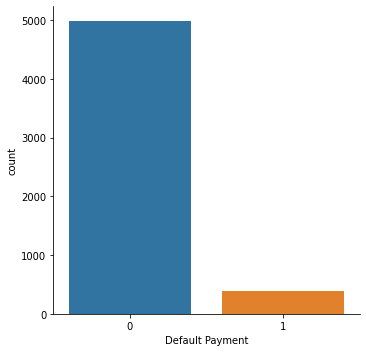

In [ ]:
plt.figure()
sns.catplot(x='Y',data=df,  kind="count").set_axis_labels("Default Payment","count")
plt.show()

## Correlation Matrix

We then looked at the correlations between the variables. The goal of this was to possibly have an overview of the explanability of our covariates towards Default Payment. Unfortunately they wasn't any high correlation between our covariates and Y.

[]

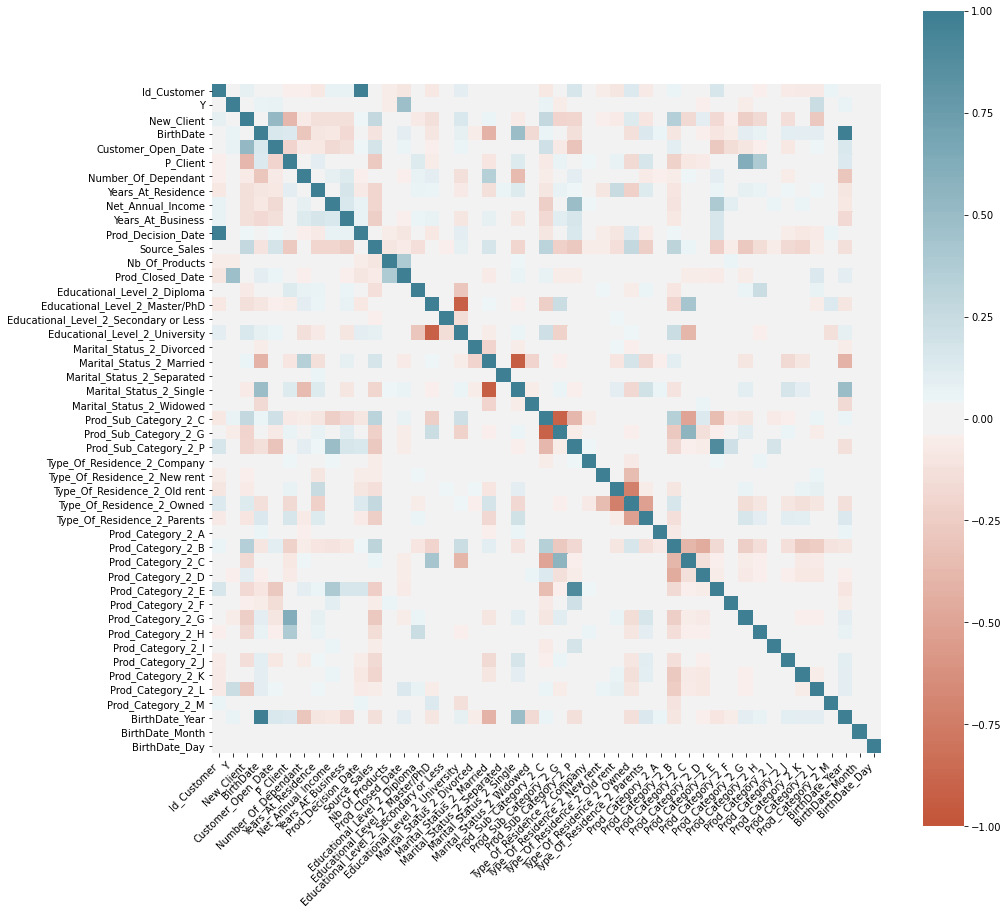

In [ ]:
plt.figure(figsize=(15,15))
correlation = df.corr()
ax = sns.heatmap(correlation, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.plot()

[]

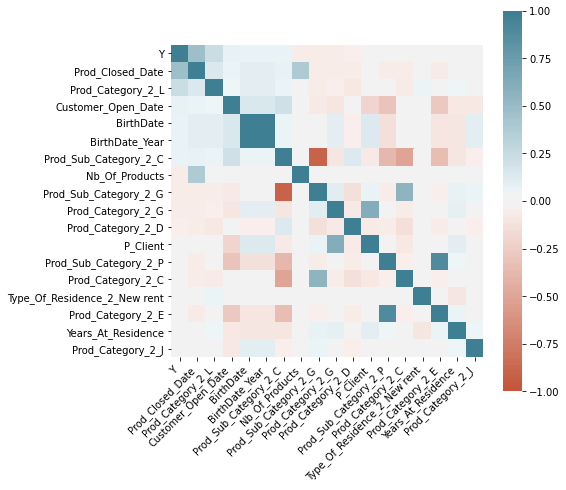

In [ ]:
plt.figure(figsize=(7,7))
indexCorr = abs(df.corr()['Y']).sort_values(ascending=False).index[:18]
dfCorr = df[indexCorr]
corrY = dfCorr.corr()
ax2 = sns.heatmap(corrY, vmin=-1, vmax=1, center=0, 
                 cmap=sns.diverging_palette(20, 220, n=200), 
                 square=True) 
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.plot()

## Other covariates analysis

Lastly, we plot graphs for each covariates to evaluate the distribution of default and non-default clients, according to these covariates.

### Client Categorization

<Figure size 432x288 with 0 Axes>

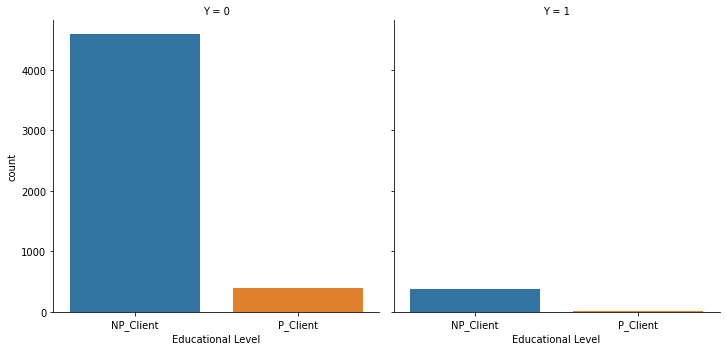

In [ ]:
plt.figure()
sns.catplot(x='P_Client_2',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Year of Birth

<Figure size 432x288 with 0 Axes>

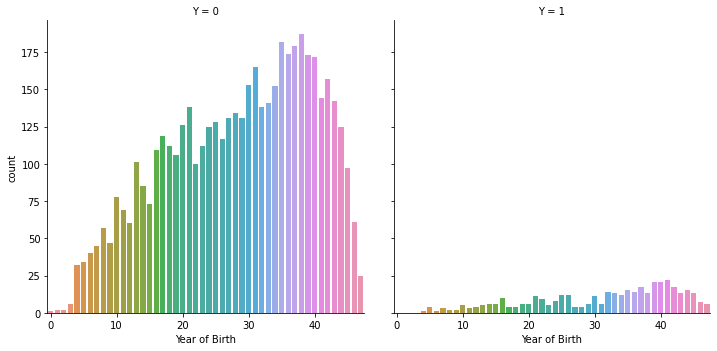

In [ ]:
plt.figure()
sns.catplot(x='BirthDate_Year',data=df, col='Y', kind="count").set_axis_labels("Year of Birth","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Month of Birth

<Figure size 432x288 with 0 Axes>

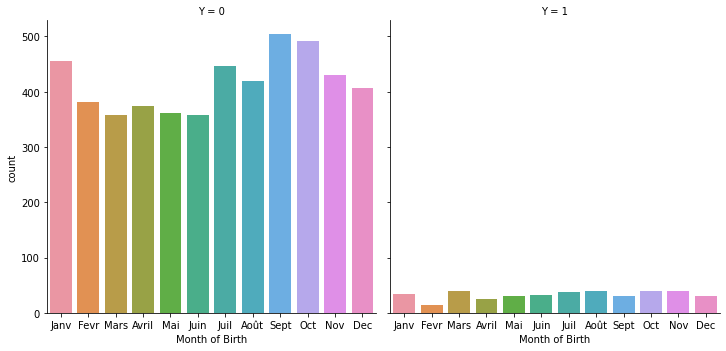

In [ ]:
plt.figure()
sns.catplot(x='BirthDate_Month',data=df, col='Y', kind="count").set_axis_labels("Month of Birth","count")
plt.gca().set_xticklabels(['Janv', 'Fevr', 'Mars', 'Avril', 'Mai', 'Juin', 'Juil', 'Août', 'Sept', 'Oct', 'Nov', 'Dec'])
plt.show()

### Day of Birth

<Figure size 432x288 with 0 Axes>

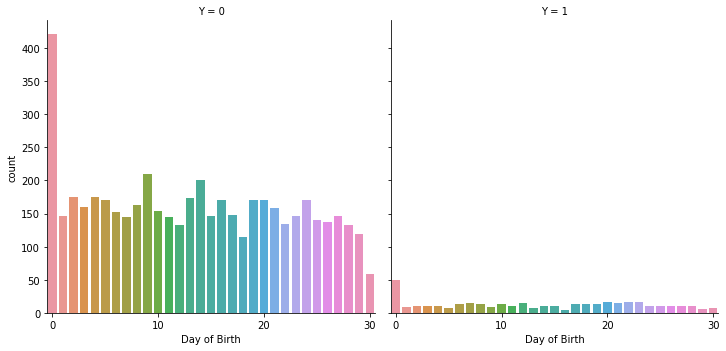

In [ ]:
plt.figure()
sns.catplot(x='BirthDate_Day',data=df, col='Y', kind="count").set_axis_labels("Day of Birth","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Educational Level

<Figure size 432x288 with 0 Axes>

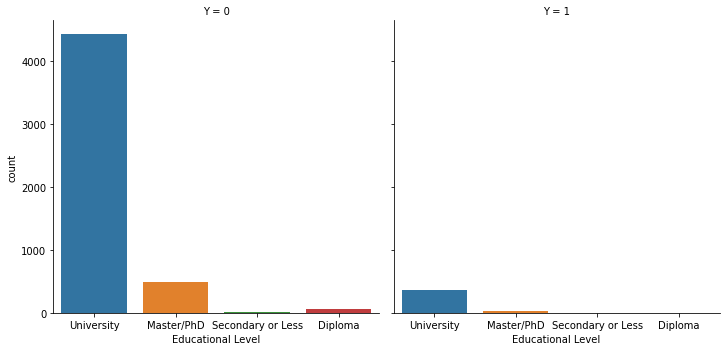

In [ ]:
plt.figure()
sns.catplot(x='Educational_Level',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Marital Status

<Figure size 432x288 with 0 Axes>

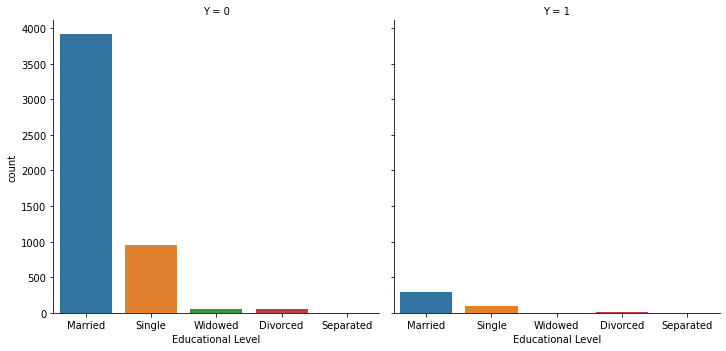

In [ ]:
plt.figure()
sns.catplot(x='Marital_Status',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Net Annual Income

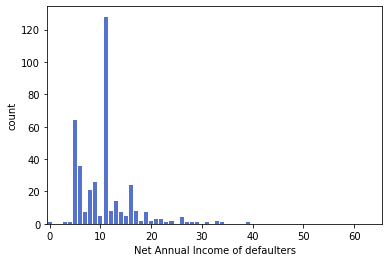

In [ ]:
plt.figure()
bins = np.arange(0, 200, 3)
binned = pd.cut(df_default['Net_Annual_Income'], bins, labels=bins[:-1], include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel("Net Annual Income of defaulters")
plt.show()

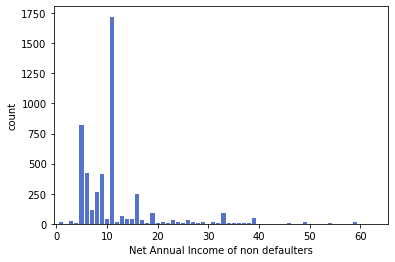

In [ ]:
plt.figure()
bins = np.arange(0, 200, 3)
binned = pd.cut(df_no_default['Net_Annual_Income'], bins, labels=bins[:-1], include_lowest=True)
sns.countplot(binned, color='royalblue')
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.xlabel("Net Annual Income of non defaulters")
plt.show()

### Type of Residence

<Figure size 432x288 with 0 Axes>

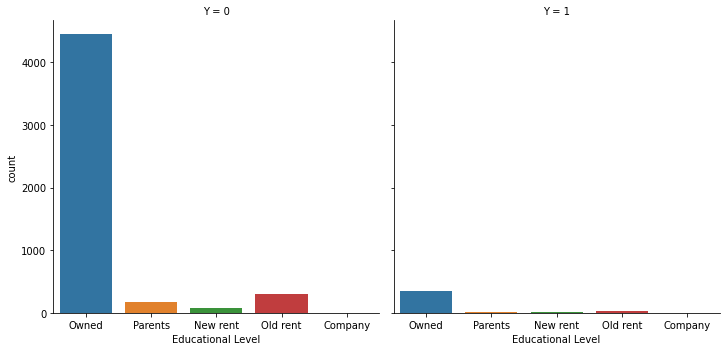

In [ ]:
plt.figure()
sns.catplot(x='Type_Of_Residence',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Years at Residence

<Figure size 432x288 with 0 Axes>

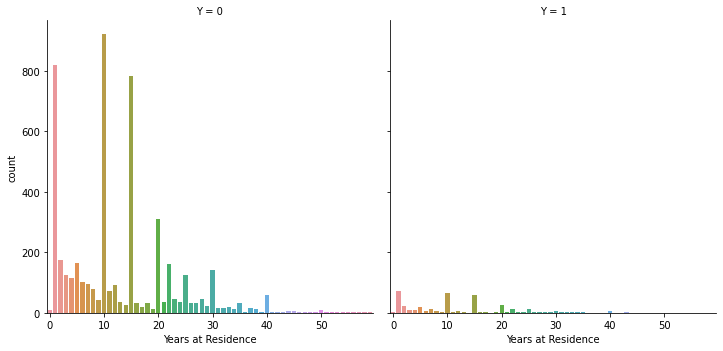

In [ ]:
plt.figure()
sns.catplot(x='Years_At_Residence',data=df, col='Y', kind="count").set_axis_labels("Years at Residence","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Years At Business

<Figure size 432x288 with 0 Axes>

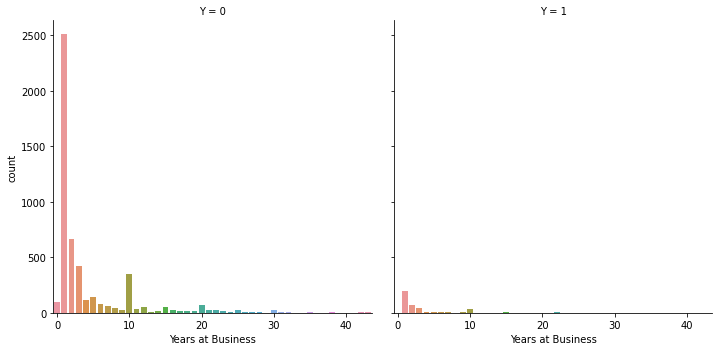

In [ ]:
plt.figure()
sns.catplot(x='Years_At_Business',data=df, col='Y', kind="count").set_axis_labels("Years at Business","count")
plt.gca().xaxis.set_major_locator(MultipleLocator(10))
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%d'))
plt.show()

### Number of Products

<Figure size 432x288 with 0 Axes>

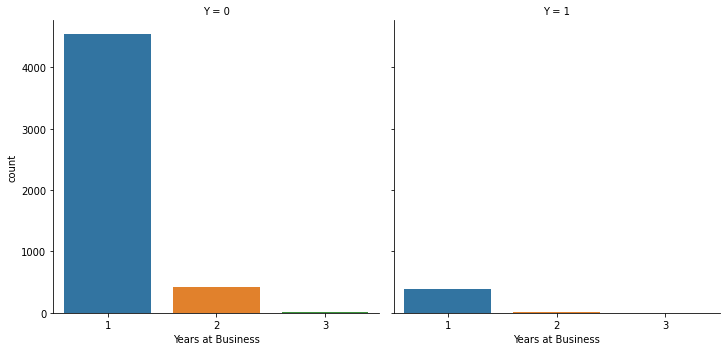

In [ ]:
plt.figure()
sns.catplot(x='Nb_Of_Products',data=df, col='Y', kind="count").set_axis_labels("Years at Business","count")
plt.show()

### Financing Source

<Figure size 432x288 with 0 Axes>

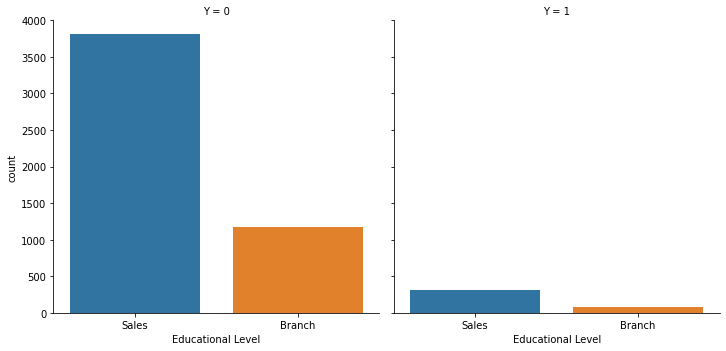

In [ ]:
plt.figure()
sns.catplot(x='Source_2',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Product Category

<Figure size 432x288 with 0 Axes>

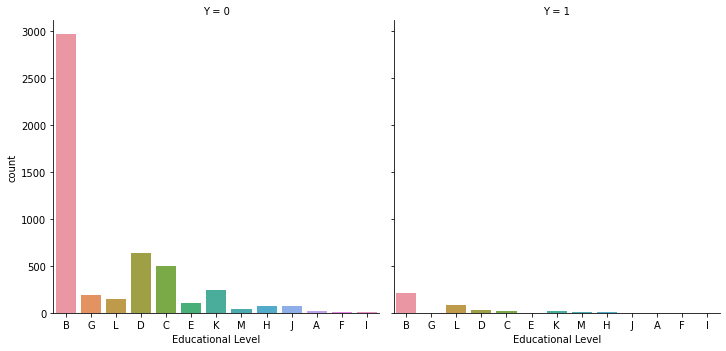

In [ ]:
plt.figure()
sns.catplot(x='Prod_Category',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Product Sub-Category

<Figure size 432x288 with 0 Axes>

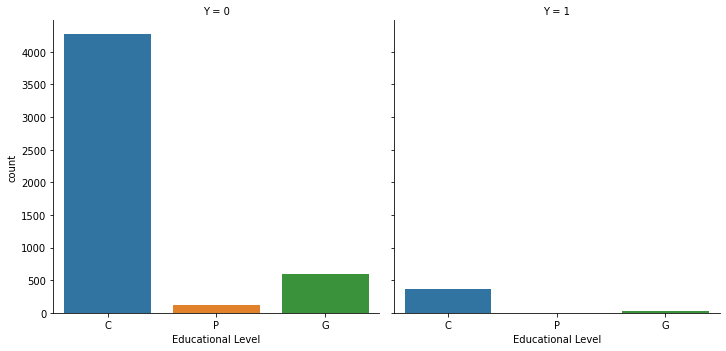

In [ ]:
plt.figure()
sns.catplot(x='Prod_Sub_Category',data=df, col='Y', kind="count").set_axis_labels("Educational Level","count")
plt.show()

### Number of Dependant

<Figure size 432x288 with 0 Axes>

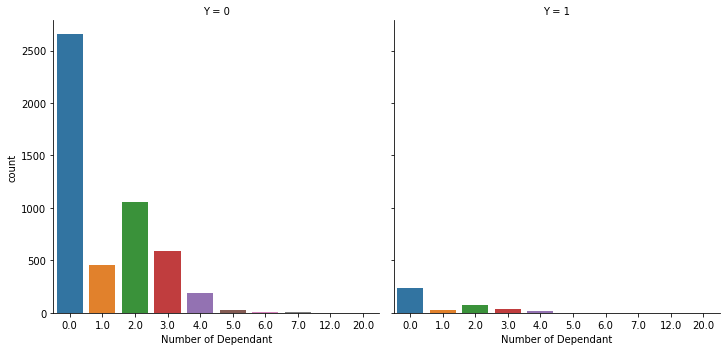

In [ ]:
plt.figure()
sns.catplot(x='Number_Of_Dependant',data=df, col='Y', kind="count").set_axis_labels("Number of Dependant","count")
plt.show()

# 2. First Machine Learning Models

We decided to use different models seen in class to classify default payment. 
We started by centering and scaling our data.
Then for each model we optimized the hyper parameters using cross validation on the training set. Once we had access to these "optimal hyperparameters", we trained our models and checked their performances on the test set. These performances were compared using classification error, AUC, ROC shape, Gini indice and learning times.

Creation of lists to gather results:

In [ ]:
resultsTrain = []
results = []
gini_train = []
gini_test = []
gini_oot = []
runtimes = []
results_labels = []

resultsRF = []
giniRF = []
results_labelsRF = []

resultsLGBM = []
giniLGBM = []
results_labelsLGBM = []

resultsRidge = []
giniRidge = []
results_labelsRidge = []

## Imputation of missing Data

We filled missing data with -1.

In [ ]:
Y = df['Y']
df['Number_Of_Dependant'] = df['Number_Of_Dependant'].fillna(-1)
df['Net_Annual_Income'] = df['Net_Annual_Income'].fillna(-1)
df['Years_At_Business'] = df['Years_At_Business'].fillna(-1)

## Drop initial categorical data after one hot encoding 

In [ ]:
df_dropped = df.drop(['Y', 'Id_Customer', 'Educational_Level', 'Marital_Status', 'Prod_Sub_Category', 'Prod_Category', 'Type_Of_Residence', 'P_Client_2', 'Source_2', 'BirthDate_Day', 'BirthDate_Month', 'BirthDate_Year'], axis=1)

## Split between Train, Test and Out-of-Time set

We split the available data: 
- 55% for train set
- 25% for test set
- 20% for out-of-time set

In [ ]:
X_tmp, X_oot, Y_tmp, Y_oot = train_test_split(df_dropped,Y,test_size= int(len(df_dropped.index)*0.2),shuffle=False)
X_train, X_test, Y_train, Y_test = train_test_split(X_tmp,Y_tmp,test_size= int(len(X_tmp.index)*0.3),random_state=11)

## 2.1 Random Forest

A first model:

In [ ]:
# parameters definition
t0 = time.time()
rf = RandomForestClassifier(max_depth = 3, max_features = 30, oob_score=True)
# learning
rfFit = rf.fit(X_train,Y_train)
runtimes.append(time.time() - t0)
print(1-rfFit.oob_score_)

0.060073016926651124


In [ ]:
# prediction error on the test set
1-rfFit.score(X_test,Y_test)

0.06274206041828045

In [ ]:
Y_pred_proba_test_rf = rfFit.predict_proba(X_test)[:,1]
Y_pred_rf = np.zeros_like(Y_test)
Y_pred_rf[Y_pred_proba_test_rf>0.007] = 1

Results storage:

In [ ]:
result_rf = 1 - metrics.accuracy_score(Y_test, Y_pred_rf)

Y_pred_proba_train_rf = rfFit.predict_proba(X_train)[:,1]
fpr_train_rf, tpr_train_rf, threshold_train_rf = metrics.roc_curve(Y_train, Y_pred_proba_train_rf)
roc_auc_train_rf = metrics.auc(fpr_train_rf, tpr_train_rf)
gini_train_rf = 2*roc_auc_train_rf - 1

Y_pred_proba_test_rf = rfFit.predict_proba(X_test)[:,1]
fpr_test_rf, tpr_test_rf, threshold_test_rf = metrics.roc_curve(Y_test, Y_pred_proba_test_rf)
roc_auc_test_rf = metrics.auc(fpr_test_rf, tpr_test_rf)
gini_test_rf = 2*roc_auc_test_rf - 1

Y_pred_proba_oot_rf = rfFit.predict_proba(X_oot)[:,1]
fpr_oot_rf, tpr_oot_rf, threshold_oot_rf = metrics.roc_curve(Y_oot, Y_pred_proba_oot_rf)
roc_auc_oot_rf = metrics.auc(fpr_oot_rf, tpr_oot_rf)
gini_oot_rf = 2*roc_auc_oot_rf - 1

results.append(result_rf)
gini_train.append(gini_train_rf)
gini_test.append(gini_test_rf)
gini_oot.append(gini_oot_rf)
results_labels.append('RF')

resultsRF.append(result_rf)
giniRF.append(gini_test_rf)
results_labelsRF.append('RF')

Features importance:

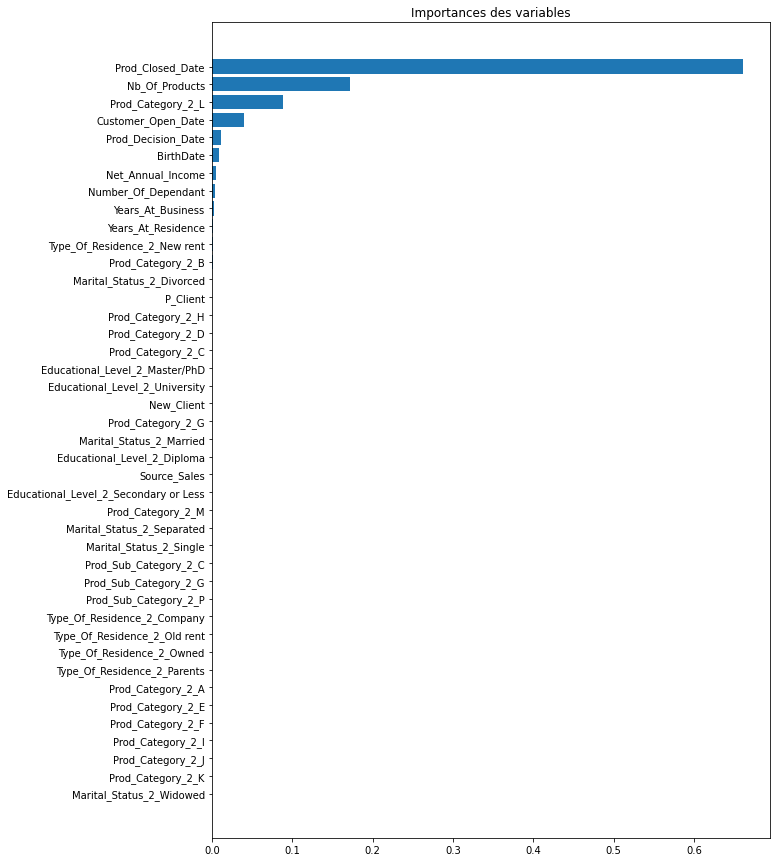

In [ ]:
# Decreasing features importance
importances_rf = rfFit.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_rf[indices_rf][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_rf[::-1]])
plt.show()

## 2.2 XGBoost

A first model:

In [ ]:
t0 = time.time()
xgb = xgboost.XGBClassifier(max_depth=2)
xgbFit = xgb.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
print(1 - xgbFit.score(X_train,Y_train))

0.039163624294722865


In [ ]:
# prediction error on the test set
1-xgbFit.score(X_test,Y_test)

0.05344694035631292

In [ ]:
Y_pred_proba_test_xgb = xgbFit.predict_proba(X_test)[:,1]
Y_pred_xgb = np.zeros_like(Y_test)
Y_pred_xgb[Y_pred_proba_test_xgb>0.008] = 1

Results storage:

In [ ]:
result_xgb = 1 - metrics.accuracy_score(Y_test, Y_pred_xgb)

Y_pred_proba_train_xgb = xgbFit.predict_proba(X_train)[:,1]
fpr_train_xgb, tpr_train_xgb, threshold_train_xgb = metrics.roc_curve(Y_train, Y_pred_proba_train_xgb)
roc_auc_train_xgb = metrics.auc(fpr_train_xgb, tpr_train_xgb)
gini_train_xgb = 2*roc_auc_train_xgb - 1

Y_pred_proba_test_xgb = xgbFit.predict_proba(X_test)[:,1]
fpr_test_xgb, tpr_test_xgb, threshold_test_xgb = metrics.roc_curve(Y_test, Y_pred_proba_test_xgb)
roc_auc_test_xgb = metrics.auc(fpr_test_xgb, tpr_test_xgb)
gini_test_xgb = 2*roc_auc_test_xgb - 1

Y_pred_proba_oot_xgb = xgbFit.predict_proba(X_oot)[:,1]
fpr_oot_xgb, tpr_oot_xgb, threshold_oot_xgb = metrics.roc_curve(Y_oot, Y_pred_proba_oot_xgb)
roc_auc_oot_xgb = metrics.auc(fpr_oot_xgb, tpr_oot_xgb)
gini_oot_xgb = 2*roc_auc_oot_xgb - 1

results.append(result_xgb)
gini_train.append(gini_train_xgb)
gini_test.append(gini_test_xgb)
gini_oot.append(gini_oot_xgb)
results_labels.append('XGB')


Features importance:

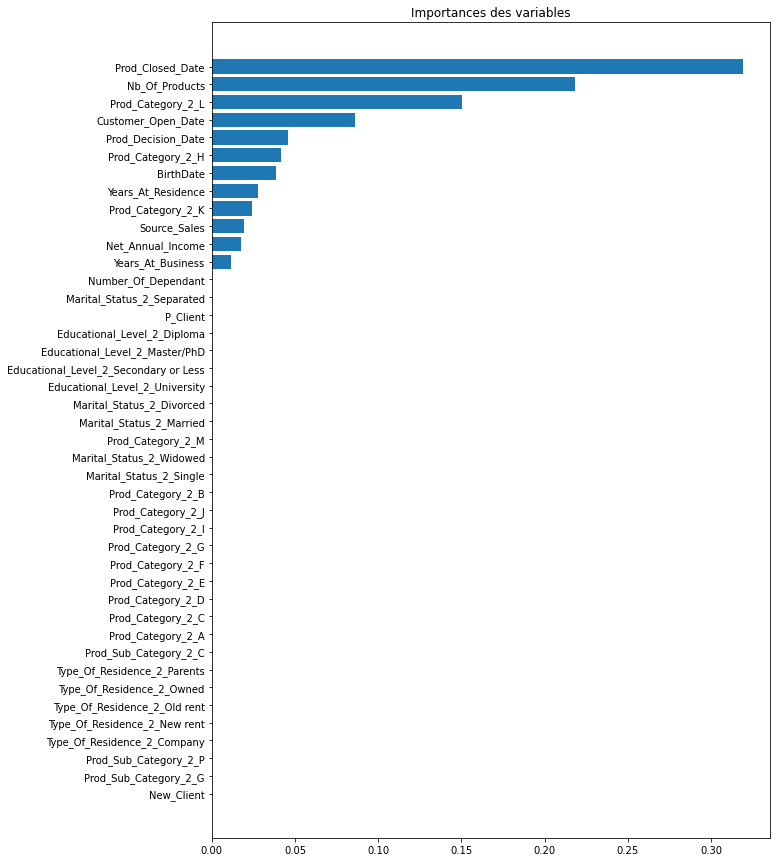

In [ ]:
# Decreasing features importance
importances_xgb = xgbFit.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_xgb[indices_xgb][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_xgb[::-1]])
plt.show()

## 2.3 LightGBM

A first model:

In [ ]:
t0 = time.time()
lgbm = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFit = lgbm.fit(X_train, Y_train)
runtimes.append(time.time() - t0)
print(1 - lgbmFit.score(X_train,Y_train))

0.035180882841022276


In [ ]:
# prediction error on the test set
1-lgbmFit.score(X_test,Y_test)

0.05731990704879941

In [ ]:
Y_pred_proba_test_lgbm = lgbmFit.predict_proba(X_test)[:,1]
Y_pred_lgbm = np.zeros_like(Y_test)
Y_pred_lgbm[Y_pred_proba_test_lgbm>0.069] = 1

Results storage:

In [ ]:
result_lgbm = 1 - metrics.accuracy_score(Y_test, Y_pred_lgbm)

Y_pred_proba_train_lgbm = lgbmFit.predict_proba(X_train)[:,1]
fpr_train_lgbm, tpr_train_lgbm, threshold_train_lgbm = metrics.roc_curve(Y_train, Y_pred_proba_train_lgbm)
roc_auc_train_lgbm = metrics.auc(fpr_train_lgbm, tpr_train_lgbm)
gini_train_lgbm = 2*roc_auc_train_lgbm - 1

Y_pred_proba_test_lgbm = lgbmFit.predict_proba(X_test)[:,1]
fpr_test_lgbm, tpr_test_lgbm, threshold_test_lgbm = metrics.roc_curve(Y_test, Y_pred_proba_test_lgbm)
roc_auc_test_lgbm = metrics.auc(fpr_test_lgbm, tpr_test_lgbm)
gini_test_lgbm = 2*roc_auc_test_lgbm - 1

Y_pred_proba_oot_lgbm = lgbmFit.predict_proba(X_oot)[:,1]
fpr_oot_lgbm, tpr_oot_lgbm, threshold_oot_lgbm = metrics.roc_curve(Y_oot, Y_pred_proba_oot_lgbm)
roc_auc_oot_lgbm = metrics.auc(fpr_oot_lgbm, tpr_oot_lgbm)
gini_oot_lgbm = 2*roc_auc_oot_lgbm - 1

results.append(result_lgbm)
gini_train.append(gini_train_lgbm)
gini_test.append(gini_test_lgbm)
gini_oot.append(gini_oot_lgbm)
results_labels.append('LGBM')

resultsLGBM.append(result_lgbm)
giniLGBM.append(gini_test_lgbm)
results_labelsLGBM.append('LGBM')

Features importance:

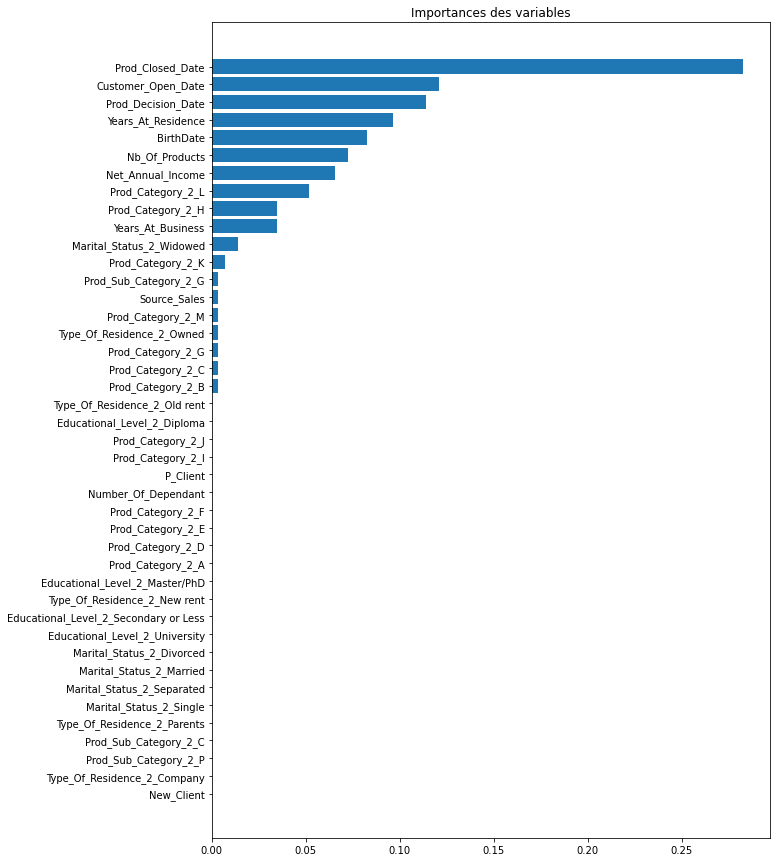

In [ ]:
# Decreasing features importance
importances_lgbm = lgbmFit.feature_importances_
importances_lgbm = importances_lgbm/importances_lgbm.sum()
indices_lgbm = np.argsort(importances_lgbm)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_lgbm[indices_lgbm][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_lgbm[::-1]])
plt.show()

## 2.4 Catboost

A first model:

In [ ]:
t0 = time.time()
catb = catboost.CatBoostClassifier(max_depth = 2)
catbFit = catb.fit(X_train, Y_train, verbose = False)
runtimes.append(time.time() - t0)
print(1 - catbFit.score(X_train,Y_train))

0.035844673083305634


In [ ]:
# prediction error on the test set
1-catbFit.score(X_test,Y_test)

0.048799380325329156

In [ ]:
Y_pred_proba_test_catb = catbFit.predict_proba(X_test)[:,1]
Y_pred_catb = np.zeros_like(Y_test)
Y_pred_catb[Y_pred_proba_test_catb>0.068] = 1

Results storage:

In [ ]:
result_catb = 1 - metrics.accuracy_score(Y_test, Y_pred_catb)

Y_pred_proba_train_catb = catbFit.predict_proba(X_train)[:,1]
fpr_train_catb, tpr_train_catb, threshold_train_catb = metrics.roc_curve(Y_train, Y_pred_proba_train_catb)
roc_auc_train_catb = metrics.auc(fpr_train_catb, tpr_train_catb)
gini_train_catb = 2*roc_auc_train_catb - 1

Y_pred_proba_test_catb = catbFit.predict_proba(X_test)[:,1]
fpr_test_catb, tpr_test_catb, threshold_test_catb = metrics.roc_curve(Y_test, Y_pred_proba_test_catb)
roc_auc_test_catb = metrics.auc(fpr_test_catb, tpr_test_catb)
gini_test_catb = 2*roc_auc_test_catb - 1

Y_pred_proba_oot_catb = catbFit.predict_proba(X_oot)[:,1]
fpr_oot_catb, tpr_oot_catb, threshold_oot_catb = metrics.roc_curve(Y_oot, Y_pred_proba_oot_catb)
roc_auc_oot_catb = metrics.auc(fpr_oot_catb, tpr_oot_catb)
gini_oot_catb = 2*roc_auc_oot_catb - 1

results.append(result_catb)
gini_train.append(gini_train_catb)
gini_test.append(gini_test_catb)
gini_oot.append(gini_oot_catb)
results_labels.append('CatBoost')

Features importance:

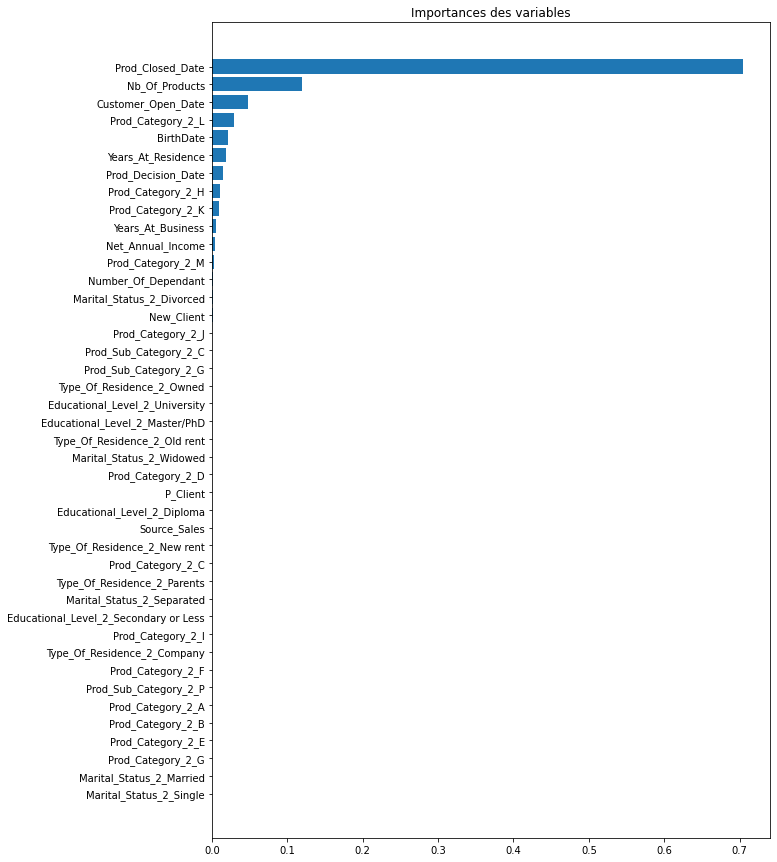

In [ ]:
# Decreasing features importance
importances_catb = catbFit.feature_importances_
importances_catb = importances_catb / importances_catb.sum()
indices_catb = np.argsort(importances_catb)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_catb[indices_catb][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_catb[::-1]])
plt.show()

## 2.5 Data Normalization

Data normalization (important for linear methods):

In [ ]:
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)
X_oot = scaler.transform(X_oot)

## 2.5 Neural Network

A first model:

In [ ]:
t0 = time.time()
nnet = MLPClassifier(hidden_layer_sizes=(10,), learning_rate_init=0.001, max_iter = 500)
nnetOpt = nnet.fit(X_train,Y_train)
runtimes.append(time.time() - t0)
print(1-nnetOpt.score(X_train,Y_train))

0.04049120477928969


In [ ]:
# prediction error on the test set 
1-nnetOpt.score(X_test,Y_test)

0.06738962044926411

In [ ]:
Y_pred_proba_test_nn = nnetOpt.predict_proba(X_test)[:,1]
Y_pred_nn = np.zeros_like(Y_test)
Y_pred_nn[Y_pred_proba_test_nn>0.0685] = 1

In [ ]:
# prévision de l'échantillon test
y_pred = nnetOpt.predict(X_test)
# matrice de confusion
table=pd.crosstab(y_pred,Y_test)
print(table)

Y         0   1
row_0          
0      1169  62
1        25  35


Results storage:

In [ ]:
result_nn = 1 - metrics.accuracy_score(Y_test, Y_pred_nn)

Y_pred_proba_train_nn = nnetOpt.predict_proba(X_train)[:,1]
fpr_train_nn, tpr_train_nn, threshold_train_nn = metrics.roc_curve(Y_train, Y_pred_proba_train_nn)
roc_auc_train_nn = metrics.auc(fpr_train_nn, tpr_train_nn)
gini_train_nn = 2*roc_auc_train_nn - 1

Y_pred_proba_test_nn = nnetOpt.predict_proba(X_test)[:,1]
fpr_test_nn, tpr_test_nn, threshold_test_nn = metrics.roc_curve(Y_test, Y_pred_proba_test_nn)
roc_auc_test_nn = metrics.auc(fpr_test_nn, tpr_test_nn)
gini_test_nn = 2*roc_auc_test_nn - 1

Y_pred_proba_oot_nn = nnetOpt.predict_proba(X_oot)[:,1]
fpr_oot_nn, tpr_oot_nn, threshold_oot_nn = metrics.roc_curve(Y_oot, Y_pred_proba_oot_nn)
roc_auc_oot_nn = metrics.auc(fpr_oot_nn, tpr_oot_nn)
gini_oot_nn = 2*roc_auc_oot_nn - 1

results.append(result_nn)
gini_train.append(gini_train_nn)
gini_test.append(gini_test_nn)
gini_oot.append(gini_oot_nn)
results_labels.append('NN')

## 2.6 Ridge

In [ ]:
# parameters definition
t0 = time.time()
ridge = RidgeClassifier(alpha=1, fit_intercept=True, normalize=False)

# learning
ridgeFit = ridge.fit(X_train,Y_train)
runtimes.append(time.time() - t0)
print(1-ridgeFit.score(X_train,Y_train))

0.060073016926651124


In [ ]:
Y_pred_proba_test_ridge = ridgeFit.decision_function(X_test)
Y_pred_ridge = np.zeros_like(Y_test)
Y_pred_ridge[Y_pred_proba_test_ridge>-0.834] = 1

Results storage:

In [ ]:
result_ridge = 1 - metrics.accuracy_score(Y_test, Y_pred_ridge)

Y_pred_proba_train_ridge = ridgeFit.decision_function(X_train)
fpr_train_ridge, tpr_train_ridge, threshold_train_ridge = metrics.roc_curve(Y_train, Y_pred_proba_train_ridge)
roc_auc_train_ridge = metrics.auc(fpr_train_ridge, tpr_train_ridge)
gini_train_ridge = 2*roc_auc_train_ridge - 1

Y_pred_proba_test_ridge = ridgeFit.decision_function(X_test)
fpr_test_ridge, tpr_test_ridge, threshold_test_ridge = metrics.roc_curve(Y_test, Y_pred_proba_test_ridge)
roc_auc_test_ridge = metrics.auc(fpr_test_ridge, tpr_test_ridge)
gini_test_ridge = 2*roc_auc_test_ridge - 1

Y_pred_proba_oot_ridge = ridgeFit.decision_function(X_oot)
fpr_oot_ridge, tpr_oot_ridge, threshold_oot_ridge = metrics.roc_curve(Y_oot, Y_pred_proba_oot_ridge)
roc_auc_oot_ridge = metrics.auc(fpr_oot_ridge, tpr_oot_ridge)
gini_oot_ridge = 2*roc_auc_oot_ridge - 1

results.append(result_ridge)
gini_train.append(gini_train_ridge)
gini_test.append(gini_test_ridge)
gini_oot.append(gini_oot_ridge)
results_labels.append('Ridge')

resultsRidge.append(result_ridge)
giniRidge.append(gini_test_ridge)
results_labelsRidge.append('Ridge')

Features importance:

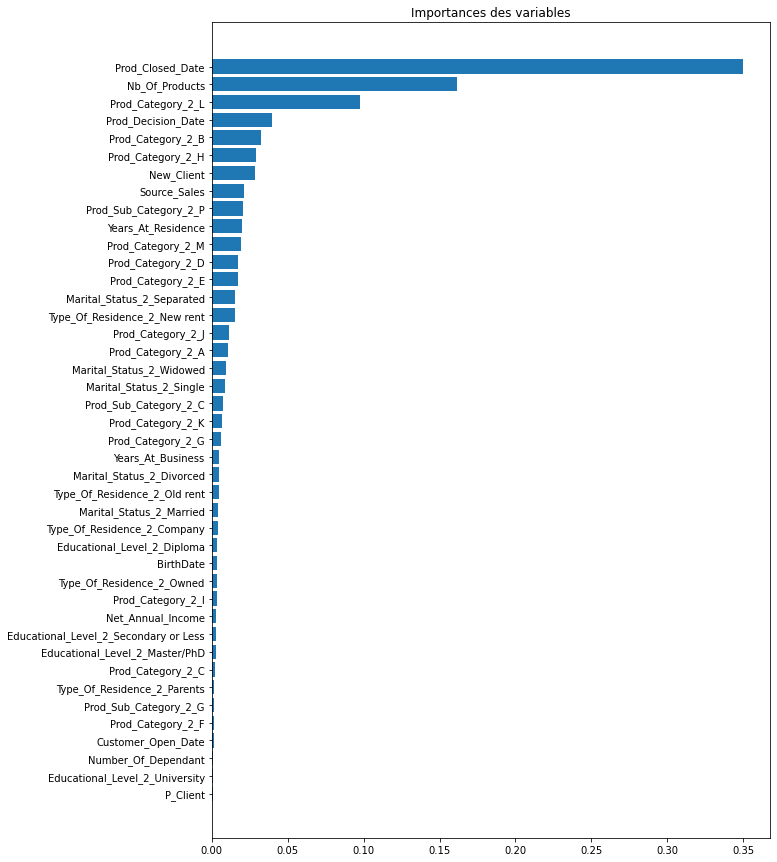

In [ ]:
# Decreasing features importance
importances_ridge = abs(ridge.coef_[0])
importances_ridge = importances_ridge/np.sum(importances_ridge)
indices_ridge = np.argsort(importances_ridge)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_ridge[indices_ridge][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_ridge[::-1]])
plt.show()

## 2.7 Logistic Classification

Model with L2 penalization:

In [ ]:
t0 = time.time()
logistic = LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear', C=0.1)
logisticFit = logistic.fit(X_train, Y_train)
print(1-logisticFit.score(X_train, Y_train))
runtimes.append(time.time() - t0)

0.05907733156322603


In [ ]:
Y_pred_proba_test_logistic = logisticFit.predict_proba(X_test)[:,1]
Y_pred_logistic = np.zeros_like(Y_test)
Y_pred_logistic[Y_pred_proba_test_logistic>0.0745] = 1

Results storage:

In [ ]:
result_logistic = 1 - metrics.accuracy_score(Y_test, Y_pred_logistic)

Y_pred_proba_train_logistic = logisticFit.predict_proba(X_train)[:,1]
fpr_train_logistic, tpr_train_logistic, threshold_train_logistic = metrics.roc_curve(Y_train, Y_pred_proba_train_logistic)
roc_auc_train_logistic = metrics.auc(fpr_train_logistic, tpr_train_logistic)
gini_train_logistic = 2*roc_auc_train_logistic - 1

Y_pred_proba_test_logistic = logisticFit.predict_proba(X_test)[:,1]
fpr_test_logistic, tpr_test_logistic, threshold_test_logistic = metrics.roc_curve(Y_test, Y_pred_proba_test_logistic)
roc_auc_test_logistic = metrics.auc(fpr_test_logistic, tpr_test_logistic)
gini_test_logistic = 2*roc_auc_test_logistic - 1

Y_pred_proba_oot_logistic = logisticFit.predict_proba(X_oot)[:,1]
fpr_oot_logistic, tpr_oot_logistic, threshold_oot_logistic = metrics.roc_curve(Y_oot, Y_pred_proba_oot_logistic)
roc_auc_oot_logistic = metrics.auc(fpr_oot_logistic, tpr_oot_logistic)
gini_oot_logistic = 2*roc_auc_oot_logistic - 1

results.append(result_logistic)
gini_train.append(gini_train_logistic)
gini_test.append(gini_test_logistic)
gini_oot.append(gini_oot_logistic)
results_labels.append('Regr Logist')

Features importance

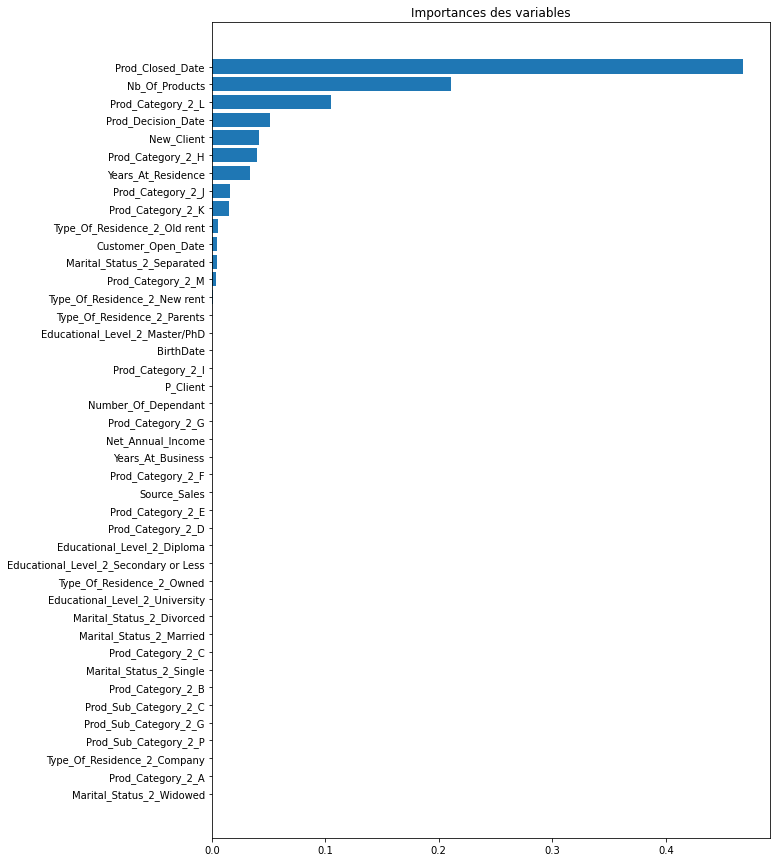

In [ ]:
# Decreasing features importance
importances_log = abs(logistic.coef_[0])
importances_log = importances_log/np.sum(importances_log)
indices_log = np.argsort(importances_log)[::-1]

plt.figure(figsize=(10,15))
plt.title("Importances des variables")
plt.barh(range(X_train.shape[1]), importances_log[indices_log][::-1], align='center')
plt.yticks(range(X_train.shape[1]), [df_dropped.columns[i] for i in indices_log[::-1]])
plt.show()

# 3. Machine Learning Models with Engineered Datasets

We compared the performances of our models when trained with different datasets:
- With less covariates (we removed the least important ones in terms of weights in our models)
- Without the outliers
- With a balanced proportion of default payment and non default payment

## 3.1 Training of models with less covariates

We tried to remove the features which had the smaller weights in our various models. We thus keep two different sets of features one with 10 features less than the initial dataset and one with 15 less.
We normalized the datasets obtained after removing the covariates.

### Feature elimination

In [ ]:
toRemoveVar = set()
bestVar = set()
listRemove = list(df_dropped.columns[indices_rf[:-5:-1]]) + list(df_dropped.columns[indices_xgb[:-5:-1]]) + list(df_dropped.columns[indices_lgbm[:-5:-1]]) + list(df_dropped.columns[indices_catb[:-5:-1]]) + list(df_dropped.columns[indices_ridge[:-5:-1]]) + list(df_dropped.columns[indices_log[:-5:-1]])
listBest = list(df_dropped.columns[indices_rf[:5]]) + list(df_dropped.columns[indices_xgb[:5]]) + list(df_dropped.columns[indices_lgbm[:5]]) + list(df_dropped.columns[indices_catb[:5]]) + list(df_dropped.columns[indices_ridge[:5]]) + list(df_dropped.columns[indices_log[:5]])

for var in listRemove :
    toRemoveVar.add(var)

for var in listBest :    
    bestVar.add(var)

toRemoveVarBig = toRemoveVar
toRemoveVarSmall = toRemoveVar.difference(bestVar)

In [ ]:
df_reduceBig = df_dropped.drop(toRemoveVarSmall, axis=1)
df_reduceSmall = df_dropped.drop(toRemoveVarBig, axis=1)
X_tmpB, X_ootB, Y_tmpB, Y_ootB = train_test_split(df_reduceBig,Y,test_size= int(len(df_reduceBig.index)*0.2),shuffle=False)
X_trainB, X_testB, Y_trainB, Y_testB = train_test_split(X_tmpB,Y_tmpB,test_size= int(len(X_tmpB.index)*0.3),random_state=11)
X_tmpS, X_ootS, Y_tmpS, Y_ootS = train_test_split(df_reduceSmall,Y,test_size= int(len(df_reduceSmall.index)*0.2),shuffle=False)
X_trainS, X_testS, Y_trainS, Y_testS = train_test_split(X_tmpS,Y_tmpS,test_size= int(len(X_tmpS.index)*0.3),random_state=11)

In [ ]:
# Normalization
scaler = StandardScaler()  
scaler.fit(X_trainS)  
X_trainS = scaler.transform(X_trainS)  
X_testS = scaler.transform(X_testS)
X_ootS = scaler.transform(X_ootS)

scaler = StandardScaler()  
scaler.fit(X_trainB)  
X_trainB = scaler.transform(X_trainB)  
X_testB = scaler.transform(X_testB)
X_ootB = scaler.transform(X_ootB)

### Random Forest

In [ ]:
rfS = RandomForestClassifier(max_depth=3)
rfFitS = rfS.fit(X_trainS, Y_trainS)
result_rfS = 1-rfFitS.score(X_testS, Y_testS)

Y_pred_test_rfS = rfFitS.predict(X_testS)
Y_pred_proba_test_rfS = rfFitS.predict_proba(X_testS)[:,1]
fpr_test_rfS, tpr_test_rfS, threshold_test_rfS = metrics.roc_curve(Y_testS, Y_pred_proba_test_rfS)
roc_auc_test_rfS = metrics.auc(fpr_test_rfS, tpr_test_rfS)
gini_test_rfS = 2*roc_auc_test_rfS - 1

resultsRF.append(result_rfS)
giniRF.append(gini_test_rfS)
results_labelsRF.append('RFVerySmallData')



rfB = RandomForestClassifier(max_depth=3)
rfFitB = rfB.fit(X_trainB, Y_trainB)
result_rfB = 1-rfFitB.score(X_testB, Y_testB)

Y_pred_test_rfB = rfFitB.predict(X_testB)
Y_pred_proba_test_rfB = rfFitB.predict_proba(X_testB)[:,1]
fpr_test_rfB, tpr_test_rfB, threshold_test_rfB = metrics.roc_curve(Y_testB, Y_pred_proba_test_rfB)
roc_auc_test_rfB = metrics.auc(fpr_test_rfB, tpr_test_rfB)
gini_test_rfB = 2*roc_auc_test_rfB - 1

resultsRF.append(result_rfB)
giniRF.append(gini_test_rfB)
results_labelsRF.append('RFSmallData')

### LightGBM

In [ ]:
lgbm3 = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitS = lgbm3.fit(X_trainS, Y_trainS)
result_lgbmS = 1-lgbmFitS.score(X_testS,Y_testS)

Y_pred_test_lgbmS = lgbmFitS.predict(X_testS)
Y_pred_proba_test_lgbmS = lgbmFitS.predict_proba(X_testS)[:,1]
fpr_test_lgbmS, tpr_test_lgbmS, threshold_test_lgbmS = metrics.roc_curve(Y_testS, Y_pred_proba_test_lgbmS)
roc_auc_test_lgbmS = metrics.auc(fpr_test_lgbmS, tpr_test_lgbmS)
gini_test_lgbmS = 2*roc_auc_test_lgbmS - 1

resultsLGBM.append(result_lgbmS)
giniLGBM.append(gini_test_lgbmS)
results_labelsLGBM.append('LGBMSVerySmallData')



lgbm4 = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitB = lgbm4.fit(X_trainB, Y_trainB)
result_lgbmB = 1-lgbmFitB.score(X_testB,Y_testB)

Y_pred_test_lgbmB = lgbmFitB.predict(X_testB)
Y_pred_proba_test_lgbmB = lgbmFitB.predict_proba(X_testB)[:,1]
fpr_test_lgbmB, tpr_test_lgbmB, threshold_test_lgbmB = metrics.roc_curve(Y_testB, Y_pred_proba_test_lgbmB)
roc_auc_test_lgbmB = metrics.auc(fpr_test_lgbmB, tpr_test_lgbmB)
gini_test_lgbmB = 2*roc_auc_test_lgbmB - 1

resultsLGBM.append(result_lgbmB)
giniLGBM.append(gini_test_lgbmB)
results_labelsLGBM.append('LGBMSmallData')

### Ridge

In [ ]:
ridge3 = RidgeClassifier()
ridgeS = ridge3.fit(X_trainS, Y_trainS)
result_ridgeS = 1-ridgeS.score(X_testS, Y_testS)

Y_pred_test_ridgeS = ridgeS.predict(X_testS)
Y_pred_proba_test_ridgeS = ridgeS.decision_function(X_testS)
fpr_test_ridgeS, tpr_test_ridgeS, threshold_test_ridgeS = metrics.roc_curve(Y_testS, Y_pred_proba_test_ridgeS)
roc_auc_test_ridgeS = metrics.auc(fpr_test_ridgeS, tpr_test_ridgeS)
gini_test_ridgeS = 2*roc_auc_test_ridgeS - 1

resultsRidge.append(result_ridgeS)
giniRidge.append(gini_test_ridgeS)
results_labelsRidge.append('RidgeVerySmallData')



ridge4 = RidgeClassifier()
ridgeB = ridge4.fit(X_trainB, Y_trainB)
result_ridgeB = 1-ridgeB.score(X_testB, Y_testB)

Y_pred_test_ridgeB = ridgeB.predict(X_testB)
Y_pred_proba_test_ridgeB = ridgeB.decision_function(X_testB)
fpr_test_ridgeB, tpr_test_ridgeB, threshold_test_ridgeB = metrics.roc_curve(Y_testB, Y_pred_proba_test_ridgeB)
roc_auc_test_ridgeB = metrics.auc(fpr_test_ridgeB, tpr_test_ridgeB)
gini_test_ridgeB = 2*roc_auc_test_ridgeB - 1

resultsRidge.append(result_ridgeB)
giniRidge.append(gini_test_ridgeB)
results_labelsRidge.append('RidgeSmallData')

## 3.2 Training without outliers

We use the Z-score to detect outliers. We use a threshold of -3.5 : 3.5 to detect outliers in the train set.



### Outlier Analysis

In [ ]:
# To have comparable results we use a random seed =11 
X_tmpOutliers, X_ootOutliers, Y_tmpOutliers, Y_ootOutliers = train_test_split(df_dropped,Y,test_size= int(len(df_dropped.index)*0.2),shuffle=False)
X_trainOutliers, X_testOutliers, Y_trainOutliers, Y_testOutliers = train_test_split(X_tmpOutliers,Y_tmpOutliers,test_size= int(len(X_tmpOutliers.index)*0.3),random_state=11)
X_trainOutliers['Y'] = Y_trainOutliers

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
X_trainOutliers = X_trainOutliers[(np.abs(stats.zscore(X_trainOutliers[['BirthDate', 'Customer_Open_Date',
                                           'Number_Of_Dependant', 'Years_At_Residence',
                                           'Net_Annual_Income', 'Years_At_Business',
                                           'Prod_Decision_Date', 'Nb_Of_Products',
                                           'Prod_Closed_Date']])) < 3.5).all(axis=1)]

In [ ]:
Y_trainOutliers = X_trainOutliers['Y']
X_trainOutliers = X_trainOutliers.drop(['Y'], axis=1)

In [ ]:
scaler = StandardScaler()  
scaler.fit(X_trainOutliers)  
X_trainOutliers = scaler.transform(X_trainOutliers)  
X_testOutliers = scaler.transform(X_testOutliers)
X_ootOutliers = scaler.transform(X_ootOutliers)

### Random Forest

In [ ]:
rfOutliers = RandomForestClassifier(max_features=30, max_depth=3)
rfFitOutliers = rfOutliers.fit(X_trainOutliers, Y_trainOutliers)
result_rfOutliers = 1-rfFitOutliers.score(X_testOutliers, Y_testOutliers)

Y_pred_test_rfOutliers = rfFitOutliers.predict(X_testOutliers)
Y_pred_proba_test_rfOutliers = rfOutliers.predict_proba(X_testOutliers)[:,1]
fpr_test_rfOutliers, tpr_test_rfOutliers, threshold_test_rfOutliers = metrics.roc_curve(Y_testOutliers, Y_pred_proba_test_rfOutliers)
roc_auc_test_rfOutliers = metrics.auc(fpr_test_rfOutliers, tpr_test_rfOutliers)
gini_test_rfOutliers = 2*roc_auc_test_rfOutliers - 1

resultsRF.append(result_rfOutliers)
giniRF.append(gini_test_rfOutliers)
results_labelsRF.append('RFOutliers')

### LightGBM

In [ ]:
lgbm2 = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitOutliers = lgbm2.fit(X_trainOutliers, Y_trainOutliers)
result_lgbmOutliers = 1-lgbmFitOutliers.score(X_testOutliers, Y_testOutliers)

Y_pred_test_lgbmOutliers = lgbmFitOutliers.predict(X_testOutliers)
Y_pred_proba_test_lgbmOutliers = lgbmFitOutliers.predict_proba(X_testOutliers)[:,1]
fpr_test_lgbmOutliers, tpr_test_lgbmOutliers, threshold_test_lgbmOutliers = metrics.roc_curve(Y_testOutliers, Y_pred_proba_test_lgbmOutliers)
roc_auc_test_lgbmOutliers = metrics.auc(fpr_test_lgbmOutliers, tpr_test_lgbmOutliers)
gini_test_lgbmOutliers = 2*roc_auc_test_lgbmOutliers - 1

resultsLGBM.append(result_lgbmOutliers)
giniLGBM.append(gini_test_lgbmOutliers)
results_labelsLGBM.append('LGBMOutliers')

### Ridge

In [ ]:
ridge2 = RidgeClassifier()
ridgeOutliers = ridge2.fit(X_trainOutliers, Y_trainOutliers)
result_ridgeOutliers = 1-ridgeOutliers.score(X_testOutliers, Y_testOutliers)

Y_pred_test_ridgeOutliers = ridgeOutliers.predict(X_testOutliers)
Y_pred_proba_test_ridgeOutliers = ridgeOutliers.decision_function(X_testOutliers)
fpr_test_ridgeOutliers, tpr_test_ridgeOutliers, threshold_test_ridgeOutliers = metrics.roc_curve(Y_testOutliers, Y_pred_proba_test_ridgeOutliers)
roc_auc_test_ridgeOutliers = metrics.auc(fpr_test_ridgeOutliers, tpr_test_ridgeOutliers)
gini_test_ridgeOutliers = 2*roc_auc_test_ridgeOutliers - 1

resultsRidge.append(result_ridgeOutliers)
giniRidge.append(gini_test_ridgeOutliers)
results_labelsRidge.append('RidgeOutliers')

## 3.3 Training on a rebalanced dataset

As the default payment class were largely under represented, we tried to compensate this bias by transforming the dataset to make it more balanced. To do so, we tried 3 techniques:
- Over representing the default payment class
- Under representing the non default payment class
- Use a combination of both previous techniques

### Rebalancing with SMOTE an Tomek techniques (Over then Under Sampling)

In [ ]:
smt = SMOTETomek(ratio='auto');
X_trainBalanced, Y_trainBalanced = smt.fit_sample(X_train, Y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
scaler = StandardScaler()  
scaler.fit(X_trainBalanced)  
X_trainBalanced = scaler.transform(X_trainBalanced)  
X_testBalanced = scaler.transform(X_test)

### Rebalancing with Random Over or Under sampling

In [ ]:
ros = RandomOverSampler()
rus = RandomUnderSampler()

X_trainUnder, Y_trainUnder = rus.fit_sample(X_train, Y_train)
X_trainOver, Y_trainOver = ros.fit_sample(X_train, Y_train)

scaler = StandardScaler()  
scaler.fit(X_trainUnder)  
X_trainUnder = scaler.transform(X_trainUnder)  
X_testUnder = scaler.transform(X_test)

scaler = StandardScaler()  
scaler.fit(X_trainOver)  
X_trainOver = scaler.transform(X_trainOver)  
X_testOver = scaler.transform(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Random Forest

In [ ]:
rfBalanced = RandomForestClassifier(max_features=30, max_depth=3)
rfFitBalanced = rfBalanced.fit(X_trainBalanced, Y_trainBalanced)
result_rfBalanced = 1-rfFitBalanced.score(X_testBalanced, Y_test)

Y_pred_test_rfBalanced = rfFitBalanced.predict(X_testBalanced)
Y_pred_proba_test_rfBalanced = rfBalanced.predict_proba(X_testBalanced)[:,1]
fpr_test_rfBalanced, tpr_test_rfBalanced, threshold_test_rfBalanced = metrics.roc_curve(Y_test, Y_pred_proba_test_rfBalanced)
roc_auc_test_rfBalanced = metrics.auc(fpr_test_rfBalanced, tpr_test_rfBalanced)
gini_test_rfBalanced = 2*roc_auc_test_rfBalanced - 1

resultsRF.append(result_rfBalanced)
giniRF.append(gini_test_rfBalanced)
results_labelsRF.append('RFOver&Under')



rfUnder = RandomForestClassifier(max_features=30, max_depth=3)
rfFitUnder = rfUnder.fit(X_trainUnder, Y_trainUnder)
result_rfUnder = 1-rfFitUnder.score(X_testUnder, Y_test)

Y_pred_test_rfUnder = rfFitUnder.predict(X_testUnder)
Y_pred_proba_test_rfUnder = rfUnder.predict_proba(X_testUnder)[:,1]
fpr_test_rfUnder, tpr_test_rfUnder, threshold_test_rfUnder = metrics.roc_curve(Y_test, Y_pred_proba_test_rfUnder)
roc_auc_test_rfUnder = metrics.auc(fpr_test_rfUnder, tpr_test_rfUnder)
gini_test_rfUnder = 2*roc_auc_test_rfUnder - 1

resultsRF.append(result_rfUnder)
giniRF.append(gini_test_rfUnder)
results_labelsRF.append('RFUnderSampl')



rfOver = RandomForestClassifier(max_features=30, max_depth=3)
rfFitOver = rfOver.fit(X_trainOver, Y_trainOver)
result_rfOver = 1-rfFitOver.score(X_testOver, Y_test)

Y_pred_test_rfOver = rfFitOver.predict(X_testOver)
Y_pred_proba_test_rfOver = rfOver.predict_proba(X_testOver)[:,1]
fpr_test_rfOver, tpr_test_rfOver, threshold_test_rfOver = metrics.roc_curve(Y_test, Y_pred_proba_test_rfOver)
roc_auc_test_rfOver = metrics.auc(fpr_test_rfOver, tpr_test_rfOver)
gini_test_rfOver = 2*roc_auc_test_rfOver - 1

resultsRF.append(result_rfOver)
giniRF.append(gini_test_rfOver)
results_labelsRF.append('RFOverSampl')

### LightGBM

In [ ]:
lgbm2 = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitBalanced = lgbm2.fit(X_trainBalanced, Y_trainBalanced)
result_lgbmBalanced = 1-lgbmFitBalanced.score(X_testBalanced, Y_test)

Y_pred_test_lgbmBalanced = lgbmFitBalanced.predict(X_testBalanced)
Y_pred_proba_test_lgbmBalanced = lgbmFitBalanced.predict_proba(X_testBalanced)[:,1]
fpr_test_lgbmBalanced, tpr_test_lgbmBalanced, threshold_test_lgbmBalanced = metrics.roc_curve(Y_test, Y_pred_proba_test_lgbmBalanced)
roc_auc_test_lgbmBalanced = metrics.auc(fpr_test_lgbmBalanced, tpr_test_lgbmBalanced)
gini_test_lgbmBalanced = 2*roc_auc_test_lgbmBalanced - 1

resultsLGBM.append(result_lgbmBalanced)
giniLGBM.append(gini_test_lgbmBalanced)
results_labelsLGBM.append('LGBMOver&Under')



lgbm = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitUnder = lgbm.fit(X_trainUnder, Y_trainUnder)
result_lgbmUnder = 1-lgbmFitUnder.score(X_testUnder, Y_test)

Y_pred_test_lgbmUnder = lgbmFitUnder.predict(X_testUnder)
Y_pred_proba_test_lgbmUnder = lgbmFitUnder.predict_proba(X_testUnder)[:,1]
fpr_test_lgbmUnder, tpr_test_lgbmUnder, threshold_test_lgbmUnder = metrics.roc_curve(Y_test, Y_pred_proba_test_lgbmUnder)
roc_auc_test_lgbmUnder = metrics.auc(fpr_test_lgbmUnder, tpr_test_lgbmUnder)
gini_test_lgbmUnder = 2*roc_auc_test_lgbmUnder - 1

resultsLGBM.append(result_lgbmUnder)
giniLGBM.append(gini_test_lgbmUnder)
results_labelsLGBM.append('LGBMUnderSampl')



lgbm = lightgbm.LGBMClassifier(max_depth = 2)
lgbmFitOver = lgbm.fit(X_trainOver, Y_trainOver)
result_lgbmOver = 1-lgbmFitOver.score(X_testOver, Y_test)

Y_pred_test_lgbmOver = lgbmFitOver.predict(X_testOver)
Y_pred_proba_test_lgbmOver = lgbmFitOver.predict_proba(X_testOver)[:,1]
fpr_test_lgbmOver, tpr_test_lgbmOver, threshold_test_lgbmOver = metrics.roc_curve(Y_test, Y_pred_proba_test_lgbmOver)
roc_auc_test_lgbmOver = metrics.auc(fpr_test_lgbmOver, tpr_test_lgbmOver)
gini_test_lgbmOver = 2*roc_auc_test_lgbmOver - 1

resultsLGBM.append(result_lgbmOver)
giniLGBM.append(gini_test_lgbmOver)
results_labelsLGBM.append('LGBMOverSampl')

### Ridge

In [ ]:
ridge2 = RidgeClassifier()

ridgeBalanced = ridge2.fit(X_trainBalanced, Y_trainBalanced)
result_ridgeBalanced = 1-ridgeBalanced.score(X_testBalanced, Y_test)

Y_pred_test_ridgeBalanced = ridgeBalanced.predict(X_testBalanced)
Y_pred_proba_test_ridgeBalanced = ridgeBalanced.decision_function(X_testBalanced)
fpr_test_ridgeBalanced, tpr_test_ridgeBalanced, threshold_test_ridgeBalanced = metrics.roc_curve(Y_test, Y_pred_proba_test_ridgeBalanced)
roc_auc_test_ridgeBalanced = metrics.auc(fpr_test_ridgeBalanced, tpr_test_ridgeBalanced)
gini_test_ridgeBalanced = 2*roc_auc_test_ridgeBalanced - 1

resultsRidge.append(result_ridgeBalanced)
giniRidge.append(gini_test_ridgeBalanced)
results_labelsRidge.append('RidgeOver&Under')



ridgeUnder = ridge2.fit(X_trainUnder, Y_trainUnder)
result_ridgeUnder = 1-ridgeUnder.score(X_testUnder, Y_test)

Y_pred_test_ridgeUnder = ridgeUnder.predict(X_testUnder)
Y_pred_proba_test_ridgeUnder = ridgeUnder.decision_function(X_testUnder)
fpr_test_ridgeUnder, tpr_test_ridgeUnder, threshold_test_ridgeUnder = metrics.roc_curve(Y_test, Y_pred_proba_test_ridgeUnder)
roc_auc_test_ridgeUnder = metrics.auc(fpr_test_ridgeUnder, tpr_test_ridgeUnder)
gini_test_ridgeUnder = 2*roc_auc_test_ridgeUnder - 1

resultsRidge.append(result_ridgeUnder)
giniRidge.append(gini_test_ridgeUnder)
results_labelsRidge.append('RidgeUnderSampl')



ridgeOver = ridge2.fit(X_trainOver, Y_trainOver)
result_ridgeOver = 1-ridgeOver.score(X_testOver, Y_test)

Y_pred_test_ridgeOver = ridgeOver.predict(X_testOver)
Y_pred_proba_test_ridgeOver = ridgeOver.decision_function(X_testOver)
fpr_test_ridgeOver, tpr_test_ridgeOver, threshold_test_ridgeOver = metrics.roc_curve(Y_test, Y_pred_proba_test_ridgeOver)
roc_auc_test_ridgeOver = metrics.auc(fpr_test_ridgeOver, tpr_test_ridgeOver)
gini_test_ridgeOver = 2*roc_auc_test_ridgeOver - 1

resultsRidge.append(result_ridgeOver)
giniRidge.append(gini_test_ridgeOver)
results_labelsRidge.append('RidgeOverSampl')

# 4. Results Comparison

## 4.1 Results without major modifications on dataset

### Error on test set

The results on the test set show that the boosting techniques clearly dominate the benchmark with a classification errror under 5%. Though there is no clear difference between LGBM, XGB and CatBoost. Moreover as clients with "Y==1" (default payment clients) represent about 8% of the clients, other metrics are very important to understand how behaves our models and if they classify efficiently the clients with "Y==1".

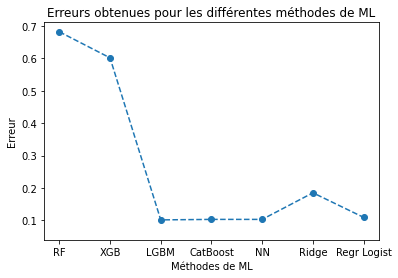

In [ ]:
plt.figure()
plt.plot(results_labels, results, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les différentes méthodes de ML")
plt.ylim(bottom = 0.04)
plt.show()

### ROC Curve and AUC

We also used the ROC curve, AUC and Gini's indice to estimate the efficiency of our techniques. In particular an AUC and a Gini's indice close to 1 illustrate good classification peridgeormances.

The graph below shows the ROC curve on the test set. We observe that the curve rise quickly to the upper left corner of the figure which illustrate good classification peridgeromances. Associated with that, AUC (Area Under the Curve) are above 0.9 for every technique and above 0.95 for the boosting techniques.

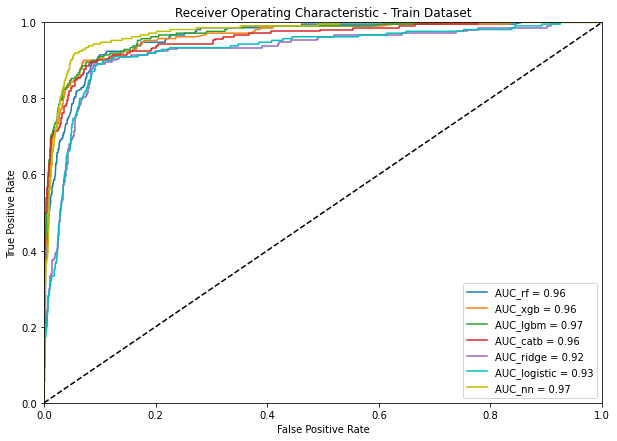

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic - Train Dataset')
plt.plot(fpr_train_rf, tpr_train_rf, label = 'AUC_rf = %0.2f' % roc_auc_train_rf)
plt.plot(fpr_train_xgb, tpr_train_xgb, label = 'AUC_xgb = %0.2f' % roc_auc_train_xgb)
plt.plot(fpr_train_lgbm, tpr_train_lgbm, label = 'AUC_lgbm = %0.2f' % roc_auc_train_lgbm)
plt.plot(fpr_train_catb, tpr_train_catb, label = 'AUC_catb = %0.2f' % roc_auc_train_catb)
plt.plot(fpr_train_ridge, tpr_train_ridge, label = 'AUC_ridge = %0.2f' % roc_auc_train_ridge)
plt.plot(fpr_train_logistic, tpr_train_logistic, 'c', label = 'AUC_logistic = %0.2f' % roc_auc_train_logistic)
plt.plot(fpr_train_nn, tpr_train_nn, 'y', label = 'AUC_nn = %0.2f' % roc_auc_train_nn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

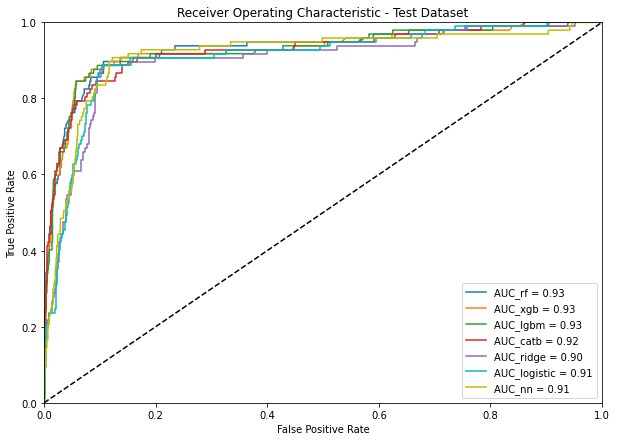

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic - Test Dataset')
plt.plot(fpr_test_rf, tpr_test_rf, label = 'AUC_rf = %0.2f' % roc_auc_test_rf)
plt.plot(fpr_test_xgb, tpr_test_xgb, label = 'AUC_xgb = %0.2f' % roc_auc_test_xgb)
plt.plot(fpr_test_lgbm, tpr_test_lgbm, label = 'AUC_lgbm = %0.2f' % roc_auc_test_lgbm)
plt.plot(fpr_test_catb, tpr_test_catb, label = 'AUC_catb = %0.2f' % roc_auc_test_catb)
plt.plot(fpr_test_ridge, tpr_test_ridge, label = 'AUC_ridge = %0.2f' % roc_auc_test_ridge)
plt.plot(fpr_test_logistic, tpr_test_logistic, 'c', label = 'AUC_logistic = %0.2f' % roc_auc_test_logistic)
plt.plot(fpr_test_nn, tpr_test_nn, 'y', label = 'AUC_nn = %0.2f' % roc_auc_test_nn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

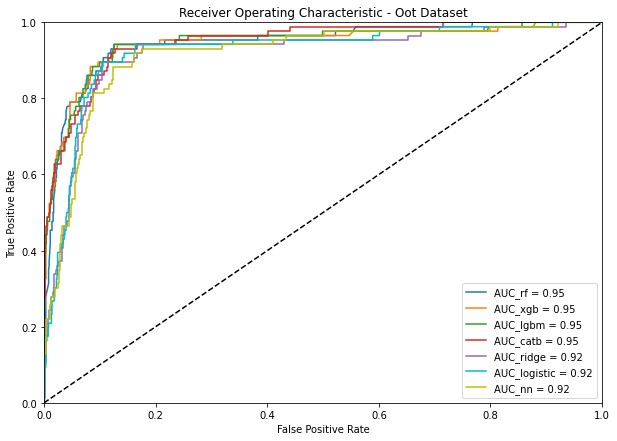

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic - Oot Dataset')
plt.plot(fpr_oot_rf, tpr_oot_rf, label = 'AUC_rf = %0.2f' % roc_auc_oot_rf)
plt.plot(fpr_oot_xgb, tpr_oot_xgb, label = 'AUC_xgb = %0.2f' % roc_auc_oot_xgb)
plt.plot(fpr_oot_lgbm, tpr_oot_lgbm, label = 'AUC_lgbm = %0.2f' % roc_auc_oot_lgbm)
plt.plot(fpr_oot_catb, tpr_oot_catb, label = 'AUC_catb = %0.2f' % roc_auc_oot_catb)
plt.plot(fpr_oot_ridge, tpr_oot_ridge, label = 'AUC_ridge = %0.2f' % roc_auc_oot_ridge)
plt.plot(fpr_oot_logistic, tpr_oot_logistic, 'c', label = 'AUC_logistic = %0.2f' % roc_auc_oot_logistic)
plt.plot(fpr_oot_nn, tpr_oot_nn, 'y', label = 'AUC_nn = %0.2f' % roc_auc_oot_nn)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Gini Indice

We used also compared Gini indices. Once again it highlighted the better performances of the boosting techniques, which all had Gini indices around 0.5 while the other techniques indices were clearly lower. 

However a Gini indice of 0.5 shows that there is still room for improvement on our model, probably because the default payment class is largely under represented.

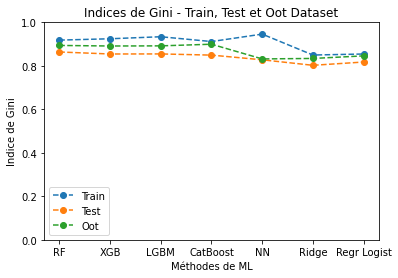

In [ ]:
plt.figure()
plt.plot(results_labels, gini_train, linestyle = 'dashed', marker = 'o', label = "Train")
plt.plot(results_labels, gini_test, linestyle = 'dashed', marker = 'o', label = "Test")
plt.plot(results_labels, gini_oot, linestyle = 'dashed', marker = 'o', label = "Oot")
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini - Train, Test et Oot Dataset")
plt.legend()
plt.ylim(bottom = 0, top = 1)
plt.show()

In [ ]:
print(gini_train)
print(gini_test)
print(gini_oot)

[0.9183816659021797, 0.924528141616975, 0.9338735708339705, 0.9117646059494078, 0.9459286818544757, 0.8497494181404277, 0.8544603571003857]
[0.8638121880882075, 0.8545217496416795, 0.8548325821547602, 0.8493498419934726, 0.8278160562261478, 0.8024832064100571, 0.8175931202403772]
[0.893880667136481, 0.8912497063659854, 0.8919074465586094, 0.8995066948555319, 0.8318299271787644, 0.8340380549682873, 0.8458656330749355]


In [ ]:
std_gini = []
for i in range(len(gini_train)):
    std_gini.append(np.std([gini_train[i], gini_test[i], gini_oot[i]]))

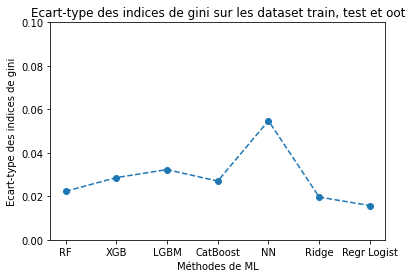

In [ ]:
plt.figure()
plt.plot(results_labels, std_gini, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Ecart-type des indices de gini")
plt.title("Ecart-type des indices de gini sur les dataset train, test et oot")
plt.ylim(bottom = 0, top = 0.1)
plt.show()

### Confusion Matrix

As ou Dataset is heavily unbalanced, the Confusion Matrix gives us important information about our model performances. It shows us that all the techniques tend to classify very often clients as "non default payment" which is quite logical as the "non default payment" are far more numerous in the training set. More specifically, we have the confirmation that boosting techniques & RF perform better than ridge, logistic classification and neural network, as they have nearly the same rates of True Negative but the rate of True Positive is far lower for NN, ridge and logistic regression than for the bagging and boosting techniques.

Consequently the Ridge, NN and Logistic regression have produced results of poorer quality for every metric considered, which lead us to choose a boosting technique or RF for our final model.

Let's now look closer at the results of the bagging and boosting techniques. Their classification leads to 91% of True Negative when 92% of the test data is actually Negative (they all have 1% False Positive). So the classification of Negative clients (non default payment, Y==0) is well done. 

Studying the True Positive and False Negative enables us to make a difference between the boosting techniques and the random forests. Indeed, sensitivities are:
- 54% for LGBM
- 53% for Catboost and XGBoost
- 46% for RF

Thus the reuslt of the boosting are more promising than the one of the random forest. Still with a sensitivity close to 50% percents for these techniques there is room for improvement. Consequently to solve this problem of classification of default payment client, we tried to modify the dataset in several ways.

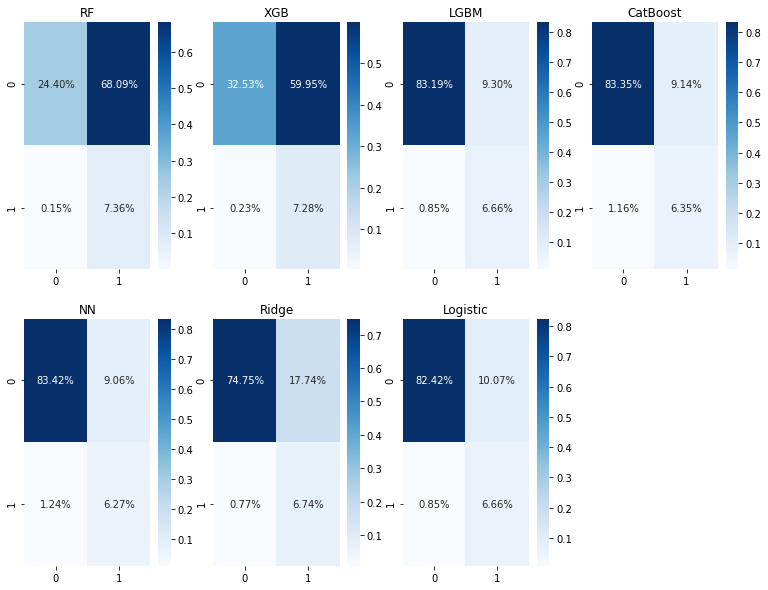

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('RF')
plt.ylabel('True Y label')
cf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('XGB')
cf_matrix_xgb = confusion_matrix(Y_test, Y_pred_xgb)
sns.heatmap(cf_matrix_xgb/np.sum(cf_matrix_xgb), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('LGBM')
cf_matrix_lgbm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cf_matrix_lgbm/np.sum(cf_matrix_lgbm), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('CatBoost')
cf_matrix_catb = confusion_matrix(Y_test, Y_pred_catb)
sns.heatmap(cf_matrix_catb/np.sum(cf_matrix_catb), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.ylabel('True Y label')
plt.xlabel('Predicted Y label')
plt.title('NN')
cf_matrix_nn = confusion_matrix(Y_test, Y_pred_nn)
sns.heatmap(cf_matrix_nn/np.sum(cf_matrix_nn), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.xlabel('Predicted Y label')
plt.title('Ridge')
cf_matrix_ridge = confusion_matrix(Y_test, Y_pred_ridge)
sns.heatmap(cf_matrix_ridge/np.sum(cf_matrix_ridge), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.xlabel('Predicted Y label')
plt.title('Logistic')
cf_matrix_logistic = confusion_matrix(Y_test, Y_pred_logistic)
sns.heatmap(cf_matrix_logistic/np.sum(cf_matrix_logistic), fmt='.2%',annot=True, cmap='Blues')

### Learning times

We also compared the learning times of our models. Even though the training is only done once we thought it would be interesting to compare this datapoint as it highlights large disparities between the techniques and also because the train set is limited to around 5000 thousands data, but one may also be interesting in training on larger datasets for which training could be more important.

This comparison sets appart two techniques whose training time are largely above the others: Neural Networks and CatBoost

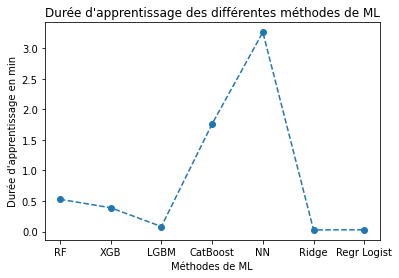

In [ ]:
plt.figure()
plt.plot(results_labels, runtimes, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Durée d'apprentissage en min")
plt.title("Durée d'apprentissage des différentes méthodes de ML")
plt.show()

## 4.2 Results with resampling, feature selection or without outliers

In this part we present the performances of several techniques when trained on modififed datasets. In particular they were trained on datasets:
- with the 15 less important removed (named after Very Small Data)
- with the 10 less important removed (named after Small Data)
- without the outliers (named after Outliers)
- with a more balanced proportion of Default payment class (Y==1) using
    - a combination of Over sampling and Under sampling (named after Balanced)
    - Over sampling only (named after Over)
    - Under sampling only (named after Under)

We display the results for 3 methods RF, LGBM and Ridge to have an overview of how would the ML methods behave. Yet while choosing our final and best model we keep in mind that LGBM had clearly better results when trained on the initial dataset.


### Error on test set

The LGBM model still outperforms the other ones no matter how engineered are the datasets. The performances are slightly better when LGBM is trained on the initial dataset. But as explained earlier, the real interest of training our engineered datasets is to try to solve the problem of predicting well the default payment class which cannot be efficiently detected with the classification error. We will be able to see this with the Confusion Matrix. 

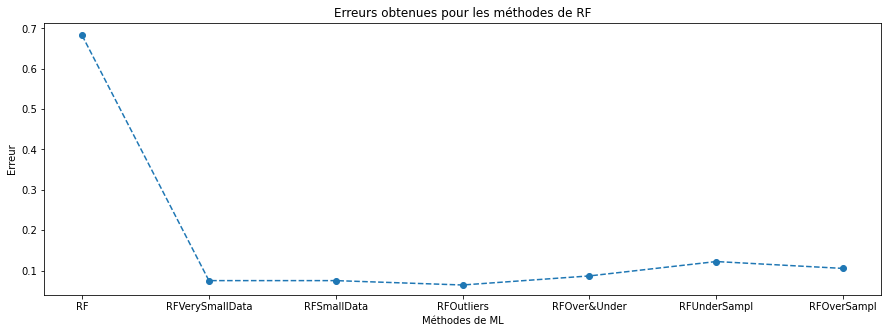

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsRF, resultsRF, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes de RF")
plt.ylim(bottom = 0.04)
plt.show()

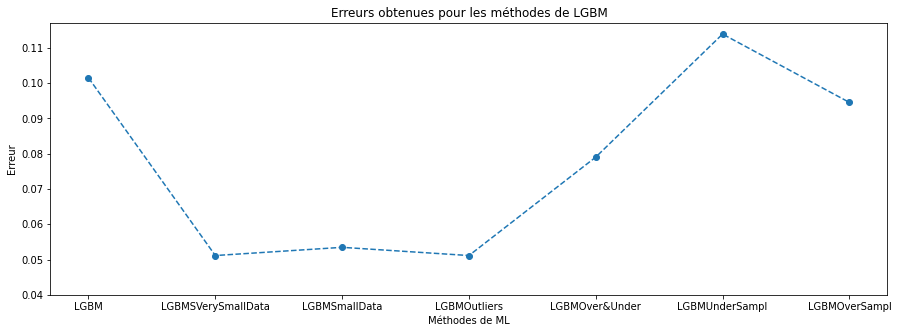

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsLGBM, resultsLGBM, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes de LGBM")
plt.ylim(bottom = 0.04)
plt.show()

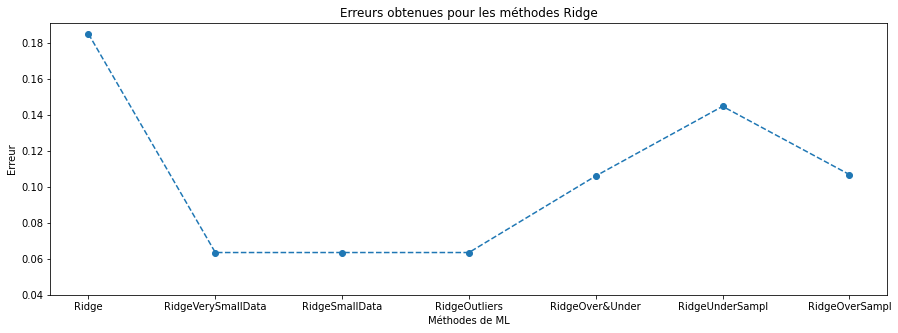

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(results_labelsRidge, resultsRidge, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Erreur")
plt.title("Erreurs obtenues pour les méthodes Ridge")
plt.ylim(bottom = 0.04)
plt.show()

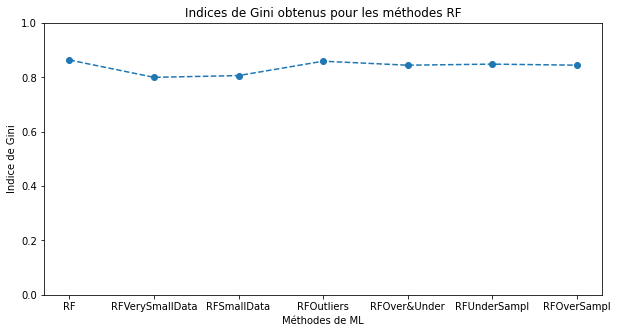

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(results_labelsRF, giniRF, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes RF")
plt.ylim(bottom = 0, top = 1)
plt.show()

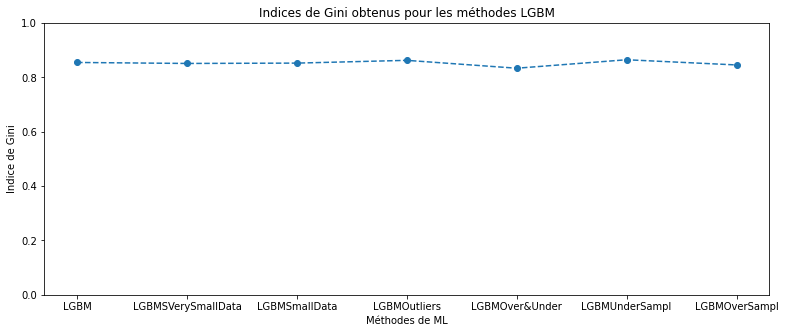

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(results_labelsLGBM, giniLGBM, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes LGBM")
plt.ylim(bottom = 0, top = 1)
plt.show()

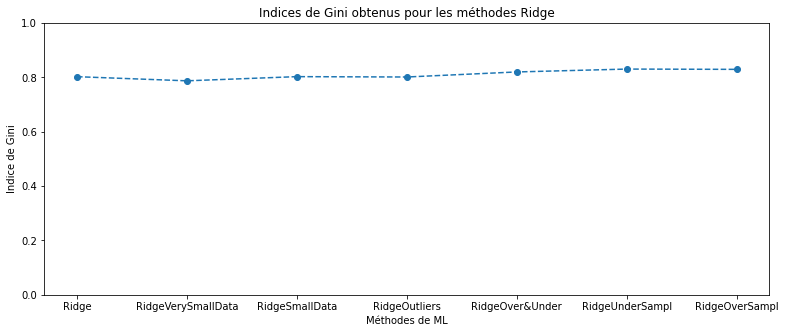

In [ ]:
plt.figure(figsize=(13,5))
plt.plot(results_labelsRidge, giniRidge, linestyle = 'dashed', marker = 'o')
plt.xlabel("Méthodes de ML")
plt.ylabel("Indice de Gini")
plt.title("Indices de Gini obtenus pour les méthodes Ridge")
plt.ylim(bottom = 0, top = 1)
plt.show()

### ROC curve


No matter on which dataset was trained the LGBM its AUC remains very close to 0.95 and the shape of the curve stuck in the upper left side of the plot which is very positive. To choose our final model, we will more rely on the Confusion Matrix.

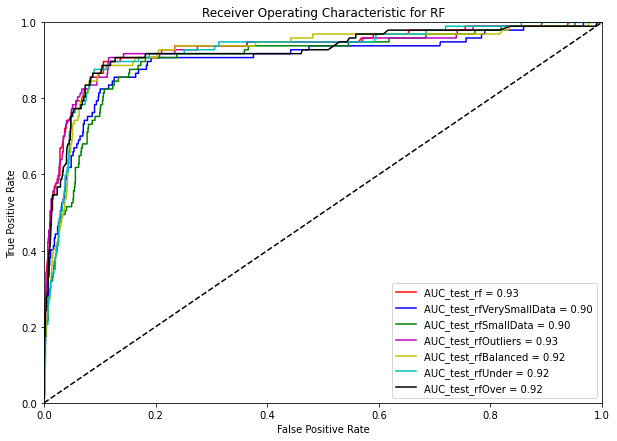

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic for RF')
plt.plot(fpr_test_rf, tpr_test_rf, 'r', label = 'AUC_test_rf = %0.2f' % roc_auc_test_rf)
plt.plot(fpr_test_rfS, tpr_test_rfS, 'b', label = 'AUC_test_rfVerySmallData = %0.2f' % roc_auc_test_rfS)
plt.plot(fpr_test_rfB, tpr_test_rfB, 'g', label = 'AUC_test_rfSmallData = %0.2f' % roc_auc_test_rfB)
plt.plot(fpr_test_rfOutliers, tpr_test_rfOutliers, 'm', label = 'AUC_test_rfOutliers = %0.2f' % roc_auc_test_rfOutliers)
plt.plot(fpr_test_rfBalanced, tpr_test_rfBalanced, 'y', label = 'AUC_test_rfBalanced = %0.2f' % roc_auc_test_rfBalanced)
plt.plot(fpr_test_rfUnder, tpr_test_rfUnder, 'c', label = 'AUC_test_rfUnder = %0.2f' % roc_auc_test_rfUnder)
plt.plot(fpr_test_rfOver, tpr_test_rfOver, 'black', label = 'AUC_test_rfOver = %0.2f' % roc_auc_test_rfOver)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

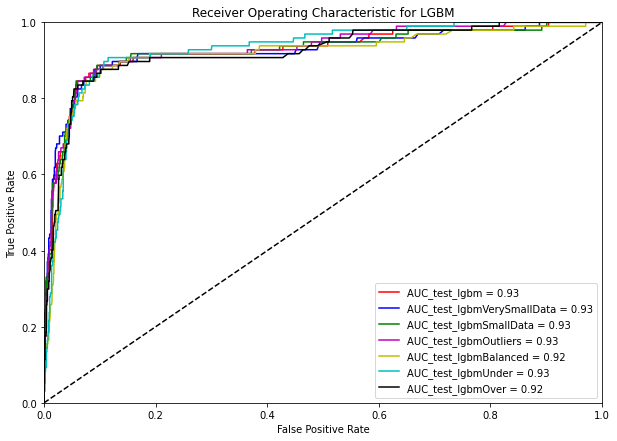

In [ ]:
plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic for LGBM')
plt.plot(fpr_test_lgbm, tpr_test_lgbm, 'r', label = 'AUC_test_lgbm = %0.2f' % roc_auc_test_lgbm)
plt.plot(fpr_test_lgbmS, tpr_test_lgbmS, 'b', label = 'AUC_test_lgbmVerySmallData = %0.2f' % roc_auc_test_lgbmS)
plt.plot(fpr_test_lgbmB, tpr_test_lgbmB, 'g', label = 'AUC_test_lgbmSmallData = %0.2f' % roc_auc_test_lgbmB)
plt.plot(fpr_test_lgbmOutliers, tpr_test_lgbmOutliers, 'm', label = 'AUC_test_lgbmOutliers = %0.2f' % roc_auc_test_lgbmOutliers)
plt.plot(fpr_test_lgbmBalanced, tpr_test_lgbmBalanced, 'y', label = 'AUC_test_lgbmBalanced = %0.2f' % roc_auc_test_lgbmBalanced)
plt.plot(fpr_test_lgbmUnder, tpr_test_lgbmUnder, 'c', label = 'AUC_test_lgbmUnder = %0.2f' % roc_auc_test_lgbmUnder)
plt.plot(fpr_test_lgbmOver, tpr_test_lgbmOver, 'black', label = 'AUC_test_lgbmOver = %0.2f' % roc_auc_test_lgbmOver)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Confusion Matrix

From the LGBM confusion matrices we can see that the quality of the classification default payment is increased only with engineered datasets tackling directly the problem of under representation of the class Y == 1.

First we can see that while undersampling our dataset (reducing the proportion of the class Y==0) the classification of the class Y==1 is the best with a sensitivity of 91%. It's overall classification error is of 11% far above the average rate of default payment client user. This means that one should use this model only if its top priority is to detect default payment clients. As we are considering default payment, this is probably the point of view of bankers or insurance workers.

If we adopt a more balanced point of view between trying to classify well both kinds of clients, the more interesting models are the models trained on the "Balanced dataset" (with Over and Under sampling) and the "Oversampling dataset". Indeed both theses techniques present very similar confusion matrix with sensitivities of 66% and 68%. Their overall classification is also similar. As the scores of LGBM trained on the over and under sampled dataset are slighlty better (classification error and Gini indice) we would choose this model.

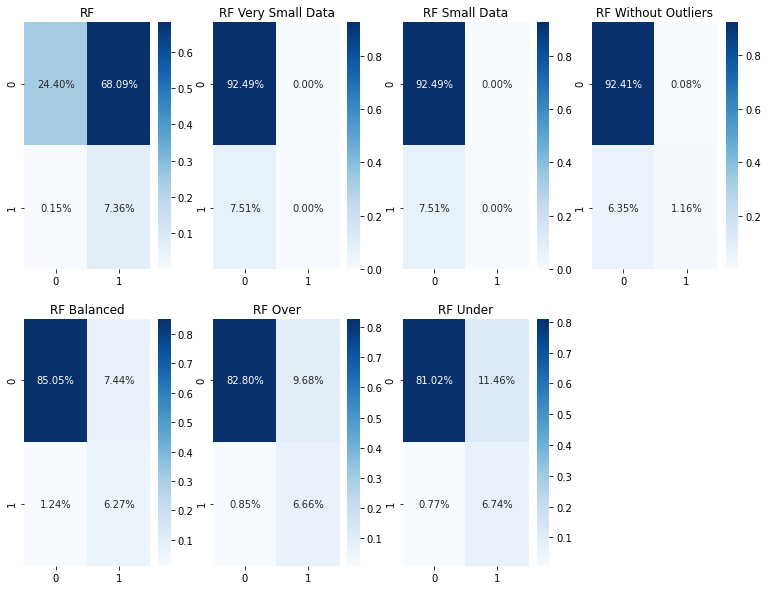

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('RF')
cf_matrix_rf = confusion_matrix(Y_test, Y_pred_rf)
sns.heatmap(cf_matrix_rf/np.sum(cf_matrix_rf), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('RF Very Small Data')
cf_matrix_rfS = confusion_matrix(Y_testS, Y_pred_test_rfS)
sns.heatmap(cf_matrix_rfS/np.sum(cf_matrix_rfS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('RF Small Data')
cf_matrix_rfB = confusion_matrix(Y_testB, Y_pred_test_rfB)
sns.heatmap(cf_matrix_rfB/np.sum(cf_matrix_rfB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('RF Without Outliers')
cf_matrix_rfOutliers = confusion_matrix(Y_testOutliers, Y_pred_test_rfOutliers)
sns.heatmap(cf_matrix_rfOutliers/np.sum(cf_matrix_rfOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('RF Balanced')
cf_matrix_rfBalanced = confusion_matrix(Y_test, Y_pred_test_rfBalanced)
sns.heatmap(cf_matrix_rfBalanced/np.sum(cf_matrix_rfBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('RF Over')
cf_matrix_rfOver = confusion_matrix(Y_test, Y_pred_test_rfOver)
sns.heatmap(cf_matrix_rfOver/np.sum(cf_matrix_rfOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('RF Under')
cf_matrix_rfUnder = confusion_matrix(Y_test, Y_pred_test_rfUnder)
sns.heatmap(cf_matrix_rfUnder/np.sum(cf_matrix_rfUnder), fmt='.2%',annot=True, cmap='Blues')

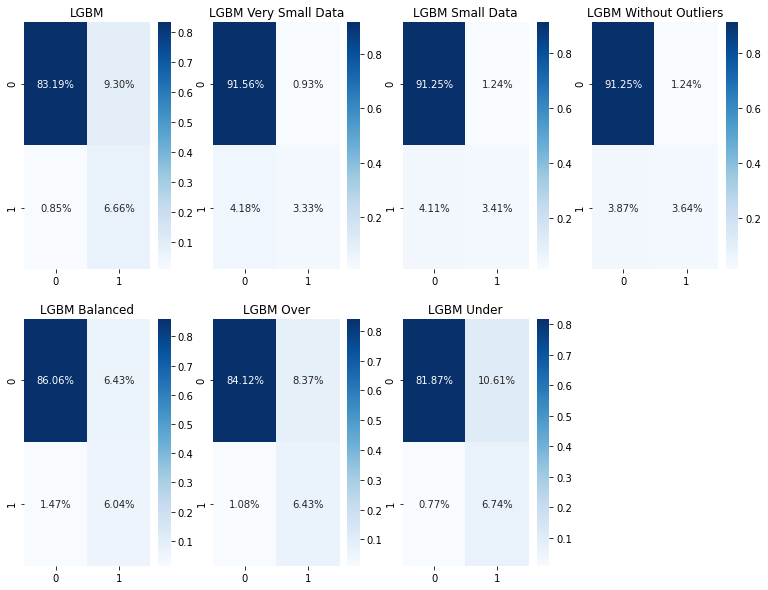

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('LGBM')
cf_matrix_lgbm = confusion_matrix(Y_test, Y_pred_lgbm)
sns.heatmap(cf_matrix_lgbm/np.sum(cf_matrix_lgbm), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('LGBM Very Small Data')
cf_matrix_lgbmS = confusion_matrix(Y_testS, Y_pred_test_lgbmS)
sns.heatmap(cf_matrix_lgbmS/np.sum(cf_matrix_lgbmS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('LGBM Small Data')
cf_matrix_lgbmB = confusion_matrix(Y_testB, Y_pred_test_lgbmB)
sns.heatmap(cf_matrix_lgbmB/np.sum(cf_matrix_lgbmB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('LGBM Without Outliers')
cf_matrix_lgbmOutliers = confusion_matrix(Y_testOutliers, Y_pred_test_lgbmOutliers)
sns.heatmap(cf_matrix_lgbmOutliers/np.sum(cf_matrix_lgbmOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('LGBM Balanced')
cf_matrix_lgbmBalanced = confusion_matrix(Y_test, Y_pred_test_lgbmBalanced)
sns.heatmap(cf_matrix_lgbmBalanced/np.sum(cf_matrix_lgbmBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('LGBM Over')
cf_matrix_lgbmOver = confusion_matrix(Y_test, Y_pred_test_lgbmOver)
sns.heatmap(cf_matrix_lgbmOver/np.sum(cf_matrix_lgbmOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('LGBM Under')
cf_matrix_lgbmUnder = confusion_matrix(Y_test, Y_pred_test_lgbmUnder)
sns.heatmap(cf_matrix_lgbmUnder/np.sum(cf_matrix_lgbmUnder), fmt='.2%',annot=True, cmap='Blues')

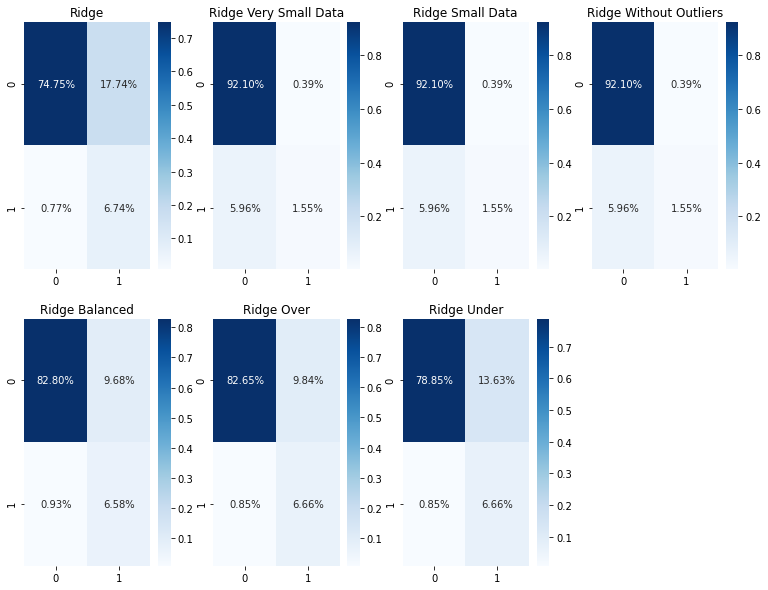

In [ ]:
plt.figure(figsize=(13,10))

plt.subplot(2, 4, 1)
plt.title('Ridge')
cf_matrix_ridge = confusion_matrix(Y_test, Y_pred_ridge)
sns.heatmap(cf_matrix_ridge/np.sum(cf_matrix_ridge), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 2)
plt.title('Ridge Very Small Data')
cf_matrix_ridgeS = confusion_matrix(Y_testS, Y_pred_test_ridgeS)
sns.heatmap(cf_matrix_ridgeS/np.sum(cf_matrix_ridgeS), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 3)
plt.title('Ridge Small Data')
cf_matrix_ridgeB = confusion_matrix(Y_testB, Y_pred_test_ridgeB)
sns.heatmap(cf_matrix_ridgeB/np.sum(cf_matrix_ridgeB), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 4)
plt.title('Ridge Without Outliers')
cf_matrix_ridgeOutliers = confusion_matrix(Y_testOutliers, Y_pred_test_ridgeOutliers)
sns.heatmap(cf_matrix_ridgeOutliers/np.sum(cf_matrix_ridgeOutliers), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 5)
plt.title('Ridge Balanced')
cf_matrix_ridgeBalanced = confusion_matrix(Y_test, Y_pred_test_ridgeBalanced)
sns.heatmap(cf_matrix_ridgeBalanced/np.sum(cf_matrix_ridgeBalanced), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 6)
plt.title('Ridge Over')
cf_matrix_ridgeOver = confusion_matrix(Y_test, Y_pred_test_ridgeOver)
sns.heatmap(cf_matrix_ridgeOver/np.sum(cf_matrix_ridgeOver), fmt='.2%',annot=True, cmap='Blues')

plt.subplot(2, 4, 7)
plt.title('Ridge Under')
cf_matrix_ridgeUnder = confusion_matrix(Y_test, Y_pred_test_ridgeUnder)
sns.heatmap(cf_matrix_ridgeUnder/np.sum(cf_matrix_ridgeUnder), fmt='.2%',annot=True, cmap='Blues')

## 4.3 Conclusion

In this project we have trained and compared several ML techniques. To do so, we first proceeded by preparing our dataset looking at the different features, then split the dataset into train and test sets and scaled the quantitative variables. After that, we trained different models on our dataset using cross validation to tune the hyper parameters. We then compared the results of our different models on the test set using different metrics: 
- classification error
- ROC curve and AUC
- Gini indice
- Confusion Matrix

The main challenge of this contests was that one of the two classes we had to predict was largely under represented (about 8% of the total data). Thus we tried to train our models on more engineered dataset to make them classify better the class Y==1. In particular, under sampling the class Y==0 or over sampling the class Y==1 show promising results.

After comparing the model performances on the different metrcis and when trained on the different dataset we would finally recommend using:
- the LGBM model trained on the dataset tuned with Over and Uner sampling
- the LGBM model trained on the dataset tuned only with Under sampling if the priority of the user is to detect the default payment client at the cost of classifying wrongly more some non default payment user. 